# Drone Localization using Multilateration with Huber Loss

This notebook estimates drone positions using RSSI measurements from beacons.

## Algorithm Overview

1. **RSSI to Distance Conversion**: Log-distance path loss model
2. **Multilateration**: Optimization to find position that best fits distance estimates
3. **Huber Loss**: Robust loss function that handles outliers
4. **Altitude Constraint**: Uses known drone altitude to improve accuracy


In [42]:
pip install numpy scipy matplotlib pyproj tqdm h5py


[notice] A new release of pip is available: 24.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [43]:
import numpy as np
import h5py  # For MATLAB v7.3 files (HDF5 format)
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyproj
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load MATLAB Simulation Data


In [44]:
# Load the MATLAB data (v7.3 format uses HDF5)
with h5py.File('data/drone_beacon_simulation_data.mat', 'r') as f:
    # Extract beacon data (h5py returns transposed arrays)
    beacon_lat = np.array(f['beaconLatitudes']).flatten()
    beacon_lon = np.array(f['beaconLongitudes']).flatten()
    beacon_x = np.array(f['beaconXMeters']).flatten()
    beacon_y = np.array(f['beaconYMeters']).flatten()
    beacon_height = float(np.array(f['beaconHeight']).flatten()[0])

    # Extract drone data
    drone_lat = np.array(f['droneLatitudes']).flatten()
    drone_lon = np.array(f['droneLongitudes']).flatten()
    drone_x = np.array(f['droneXMeters']).flatten()
    drone_y = np.array(f['droneYMeters']).flatten()
    drone_altitude = float(np.array(f['droneAltitude']).flatten()[0])

    # Extract RSSI and true distances (transpose for correct orientation)
    rssi_matrix = np.array(f['rssi_matrix']).T  # [num_drone_positions x num_beacons]
    true_distances = np.array(f['true_distances']).T  # [num_drone_positions x num_beacons]

    # Extract metadata (h5py handles structs differently)
    metadata_group = f['metadata']
    map_origin_lat = float(np.array(metadata_group['mapOriginLat']).flatten()[0])
    map_origin_lon = float(np.array(metadata_group['mapOriginLon']).flatten()[0])
    map_size_meters = float(np.array(metadata_group['mapSizeMeters']).flatten()[0])
    deg_per_meter_lat = float(np.array(metadata_group['degPerMeterLat']).flatten()[0])
    deg_per_meter_lon = float(np.array(metadata_group['degPerMeterLon']).flatten()[0])

num_beacons = len(beacon_lat)
num_drone_positions = len(drone_lat)

print(f"Data loaded successfully!")
print(f"  - Number of beacons: {num_beacons}")
print(f"  - Number of drone positions: {num_drone_positions}")
print(f"  - Drone altitude: {drone_altitude} m")
print(f"  - Beacon height: {beacon_height} m")
print(f"  - Map size: {map_size_meters} x {map_size_meters} m")
print(f"  - RSSI range: [{rssi_matrix.min():.2f}, {rssi_matrix.max():.2f}] dBm")
print(f"  - Distance range: [{true_distances.min():.2f}, {true_distances.max():.2f}] m")


Data loaded successfully!
  - Number of beacons: 64
  - Number of drone positions: 400
  - Drone altitude: 100.0 m
  - Beacon height: 1.0 m
  - Map size: 4000.0 x 4000.0 m
  - RSSI range: [-152.08, -43.04] dBm
  - Distance range: [100.38, 5239.52] m


## 2. Visualize Data


## 2.5 Analyze RSSI Distribution & Filter NLOS Signals

**Problem Identified**: The Longley-Rice model produces many NLOS (Non-Line-of-Sight) signals with very low RSSI values that:
1. Would not be received in practice (below receiver sensitivity of -135 dBm)
2. Corrupt the RSSI-to-distance model fitting
3. Cause huge localization errors

**Solution**: Filter out weak signals and refit the model using only reliable LOS signals.


RSSI DISTRIBUTION ANALYSIS
Total signals: 25600
Signals below -135 dBm: 778 (3.0%)
RSSI range: [-152.1, -43.0] dBm
RSSI mean: -93.2 dBm
RSSI median: -87.4 dBm


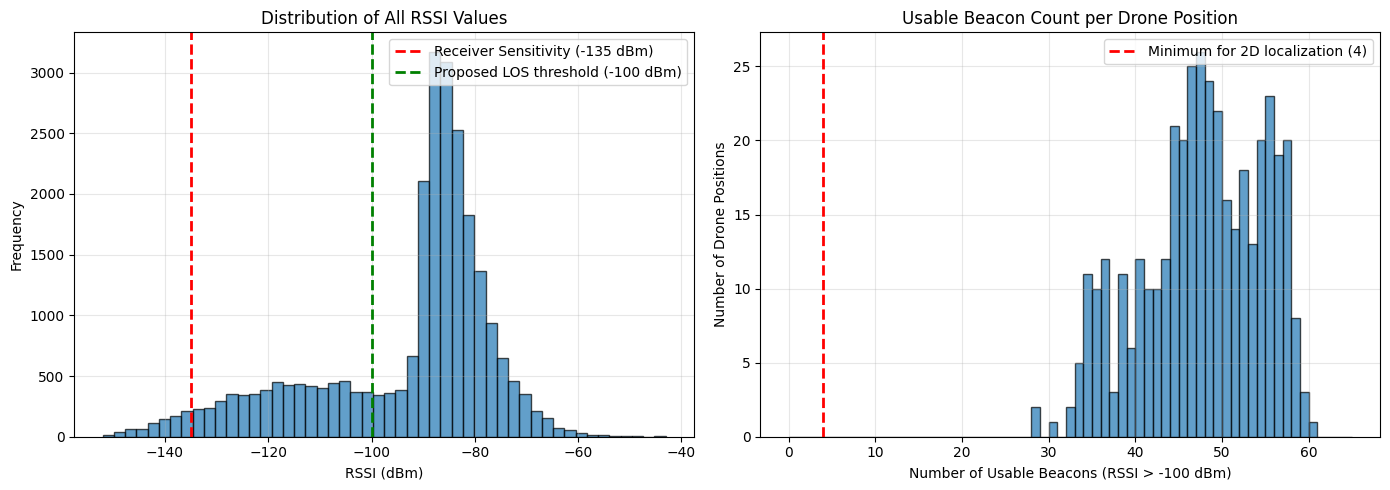


Usable beacons per position (RSSI > -100 dBm):
  Min: 28, Max: 60, Mean: 47.2


In [45]:
# Analyze RSSI distribution
RECEIVER_SENSITIVITY = -135  # dBm (from MATLAB code)

# Count signals below sensitivity
below_sensitivity = np.sum(rssi_matrix < RECEIVER_SENSITIVITY)
total_signals = rssi_matrix.size
pct_below = 100 * below_sensitivity / total_signals

print("="*60)
print("RSSI DISTRIBUTION ANALYSIS")
print("="*60)
print(f"Total signals: {total_signals}")
print(f"Signals below {RECEIVER_SENSITIVITY} dBm: {below_sensitivity} ({pct_below:.1f}%)")
print(f"RSSI range: [{rssi_matrix.min():.1f}, {rssi_matrix.max():.1f}] dBm")
print(f"RSSI mean: {rssi_matrix.mean():.1f} dBm")
print(f"RSSI median: {np.median(rssi_matrix):.1f} dBm")

# Histogram of RSSI values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(rssi_matrix.flatten(), bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(RECEIVER_SENSITIVITY, color='r', linestyle='--', linewidth=2, 
            label=f'Receiver Sensitivity ({RECEIVER_SENSITIVITY} dBm)')
ax1.axvline(-100, color='g', linestyle='--', linewidth=2, 
            label='Proposed LOS threshold (-100 dBm)')
ax1.set_xlabel('RSSI (dBm)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of All RSSI Values')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Per-drone position: count of "usable" signals
ax2 = axes[1]
usable_per_drone = np.sum(rssi_matrix > -100, axis=1)
ax2.hist(usable_per_drone, bins=range(0, num_beacons+2), edgecolor='black', alpha=0.7)
ax2.axvline(4, color='r', linestyle='--', linewidth=2, label='Minimum for 2D localization (4)')
ax2.set_xlabel('Number of Usable Beacons (RSSI > -100 dBm)')
ax2.set_ylabel('Number of Drone Positions')
ax2.set_title('Usable Beacon Count per Drone Position')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nUsable beacons per position (RSSI > -100 dBm):")
print(f"  Min: {usable_per_drone.min()}, Max: {usable_per_drone.max()}, Mean: {usable_per_drone.mean():.1f}")


Fitting model with 18875 LOS signals (RSSI > -100 dBm)
This is 73.7% of all signals

LOS-only RSSI-to-Distance Model:
  RSSI = -19.8679 - 10 * 2.0066 * log10(d)
  A = -19.8679
  n = 2.0066 (path loss exponent)

Compare to ALL-data model: A=23.07, n=3.58
Note: LOS model has lower n, closer to free-space (n=2)


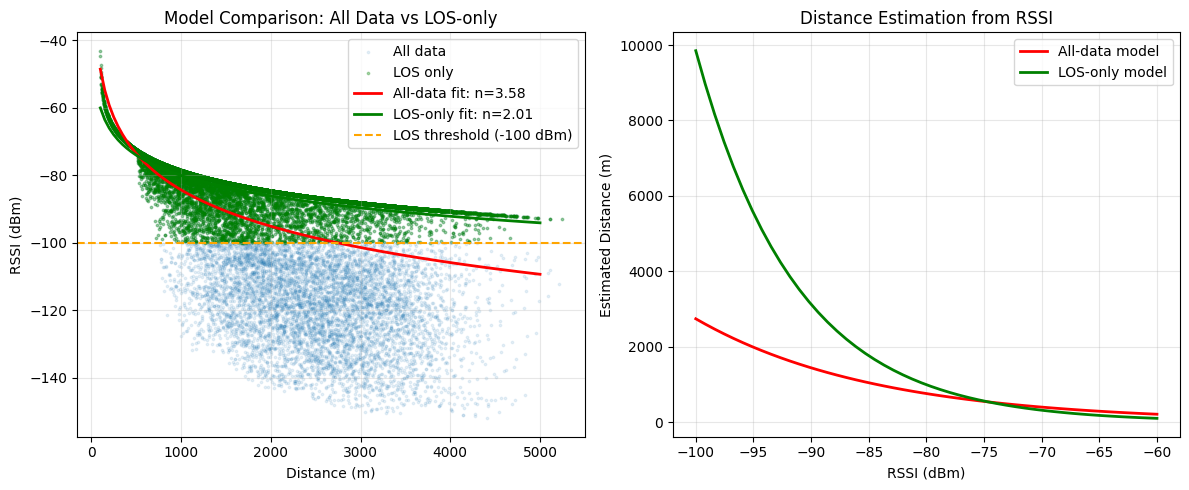

In [46]:
# Refit model using only LOS signals (RSSI > threshold)
LOS_THRESHOLD = -100  # dBm - only use strong signals for model fitting

# Filter for LOS signals
los_mask = (rssi_matrix.flatten() > LOS_THRESHOLD) & (true_distances.flatten() > 0)
los_distances = true_distances.flatten()[los_mask]
los_rssi = rssi_matrix.flatten()[los_mask]

print(f"Fitting model with {len(los_rssi)} LOS signals (RSSI > {LOS_THRESHOLD} dBm)")
print(f"This is {100*len(los_rssi)/rssi_matrix.size:.1f}% of all signals")

# Refit the log-distance model
popt_los, _ = curve_fit(log_distance_model, los_distances, los_rssi, p0=[-30, 2])
A_fit_los, n_fit_los = popt_los

print(f"\nLOS-only RSSI-to-Distance Model:")
print(f"  RSSI = {A_fit_los:.4f} - 10 * {n_fit_los:.4f} * log10(d)")
print(f"  A = {A_fit_los:.4f}")
print(f"  n = {n_fit_los:.4f} (path loss exponent)")
print(f"\nCompare to ALL-data model: A={A_fit:.2f}, n={n_fit:.2f}")
print(f"Note: LOS model has lower n, closer to free-space (n=2)")

# Visualize comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(valid_distances, valid_rssi, alpha=0.1, s=3, label='All data')
plt.scatter(los_distances, los_rssi, alpha=0.3, s=3, c='green', label='LOS only')
d_range = np.linspace(100, 5000, 100)
plt.plot(d_range, log_distance_model(d_range, A_fit, n_fit), 'r-', linewidth=2, 
         label=f'All-data fit: n={n_fit:.2f}')
plt.plot(d_range, log_distance_model(d_range, A_fit_los, n_fit_los), 'g-', linewidth=2, 
         label=f'LOS-only fit: n={n_fit_los:.2f}')
plt.axhline(LOS_THRESHOLD, color='orange', linestyle='--', label=f'LOS threshold ({LOS_THRESHOLD} dBm)')
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dBm)')
plt.title('Model Comparison: All Data vs LOS-only')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show distance estimation error for a sample RSSI value
rssi_test = np.linspace(-60, -100, 50)
d_all = rssi_to_distance(rssi_test, A_fit, n_fit)
d_los = rssi_to_distance(rssi_test, A_fit_los, n_fit_los)
plt.plot(rssi_test, d_all, 'r-', linewidth=2, label='All-data model')
plt.plot(rssi_test, d_los, 'g-', linewidth=2, label='LOS-only model')
plt.xlabel('RSSI (dBm)')
plt.ylabel('Estimated Distance (m)')
plt.title('Distance Estimation from RSSI')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2.6 Run Localization with RSSI Filtering (LOS-only)

Now run multilateration using only beacons with RSSI above threshold, excluding NLOS contaminated signals.


In [47]:
def multilaterate_filtered(beacon_locations_all, rssi_values, target_altitude, 
                            rssi_threshold=-100, min_beacons=4, delta=10.0):
    """
    Multilateration using only beacons with RSSI above threshold.
    
    Returns None if insufficient beacons available.
    """
    # Filter beacons by RSSI threshold
    valid_mask = rssi_values > rssi_threshold
    
    if np.sum(valid_mask) < min_beacons:
        return None, None, np.sum(valid_mask)
    
    # Get valid beacons and their RSSI
    valid_beacon_locs = [beacon_locations_all[i] for i in range(len(beacon_locations_all)) if valid_mask[i]]
    valid_rssi = rssi_values[valid_mask]
    
    # Convert RSSI to distance using LOS-fitted model
    estimated_distances = rssi_to_distance(valid_rssi, A_fit_los, n_fit_los)
    
    # Run multilateration
    estimated_pos, loss = multilaterate(
        valid_beacon_locs,
        estimated_distances,
        target_altitude,
        delta=delta,
        use_altitude_constraint=True
    )
    
    return estimated_pos, loss, np.sum(valid_mask)

# Run filtered localization
print(f"Running FILTERED multilateration (RSSI > {LOS_THRESHOLD} dBm)...")
print(f"Using LOS-only model: A={A_fit_los:.2f}, n={n_fit_los:.2f}")

estimated_positions_filtered = []
errors_2d_filtered = []
errors_3d_filtered = []
num_beacons_used = []
skipped_count = 0

for i in tqdm(range(num_drone_positions)):
    rssi_values = rssi_matrix[i, :]
    
    estimated_pos, loss, n_beacons = multilaterate_filtered(
        beacon_locations, 
        rssi_values, 
        drone_altitude,
        rssi_threshold=LOS_THRESHOLD,
        min_beacons=4,
        delta=10.0
    )
    
    if estimated_pos is None:
        skipped_count += 1
        estimated_positions_filtered.append(None)
        errors_2d_filtered.append(np.nan)
        errors_3d_filtered.append(np.nan)
        num_beacons_used.append(n_beacons)
        continue
    
    estimated_positions_filtered.append(estimated_pos)
    num_beacons_used.append(n_beacons)
    
    # Calculate errors
    true_pos_2d = to_cartesian_2d(drone_lat[i], drone_lon[i])
    est_pos_2d = to_cartesian_2d(estimated_pos[0], estimated_pos[1])
    errors_2d_filtered.append(np.linalg.norm(true_pos_2d - est_pos_2d))
    
    true_pos_3d = to_cartesian(drone_lat[i], drone_lon[i], drone_altitude)
    est_pos_3d = to_cartesian(*estimated_pos)
    errors_3d_filtered.append(np.linalg.norm(true_pos_3d - est_pos_3d))

errors_2d_filtered = np.array(errors_2d_filtered)
errors_3d_filtered = np.array(errors_3d_filtered)
num_beacons_used = np.array(num_beacons_used)

# Remove NaN for statistics
valid_errors_2d = errors_2d_filtered[~np.isnan(errors_2d_filtered)]
valid_errors_3d = errors_3d_filtered[~np.isnan(errors_3d_filtered)]

print(f"\nFiltered localization complete!")
print(f"Skipped {skipped_count} positions (insufficient beacons)")
print(f"Successfully localized: {len(valid_errors_2d)} / {num_drone_positions}")


Running FILTERED multilateration (RSSI > -100 dBm)...
Using LOS-only model: A=-19.87, n=2.01


100%|██████████| 400/400 [00:02<00:00, 138.62it/s]


Filtered localization complete!
Skipped 0 positions (insufficient beacons)
Successfully localized: 400 / 400


COMPARISON: Original (All Signals) vs Filtered (LOS-only)

Metric                                   Original     Filtered (LOS)
----------------------------------------------------------------------
Mean 2D Error (m)                          977.50             332.27
Median 2D Error (m)                        769.72             335.11
Std 2D Error (m)                           749.61             112.77
Min 2D Error (m)                            28.21              72.06
Max 2D Error (m)                          3350.99             612.77
----------------------------------------------------------------------
Positions Localized                           400                400
Avg Beacons Used                               64               47.2

>>> IMPROVEMENT: 66.0% reduction in mean error <<<


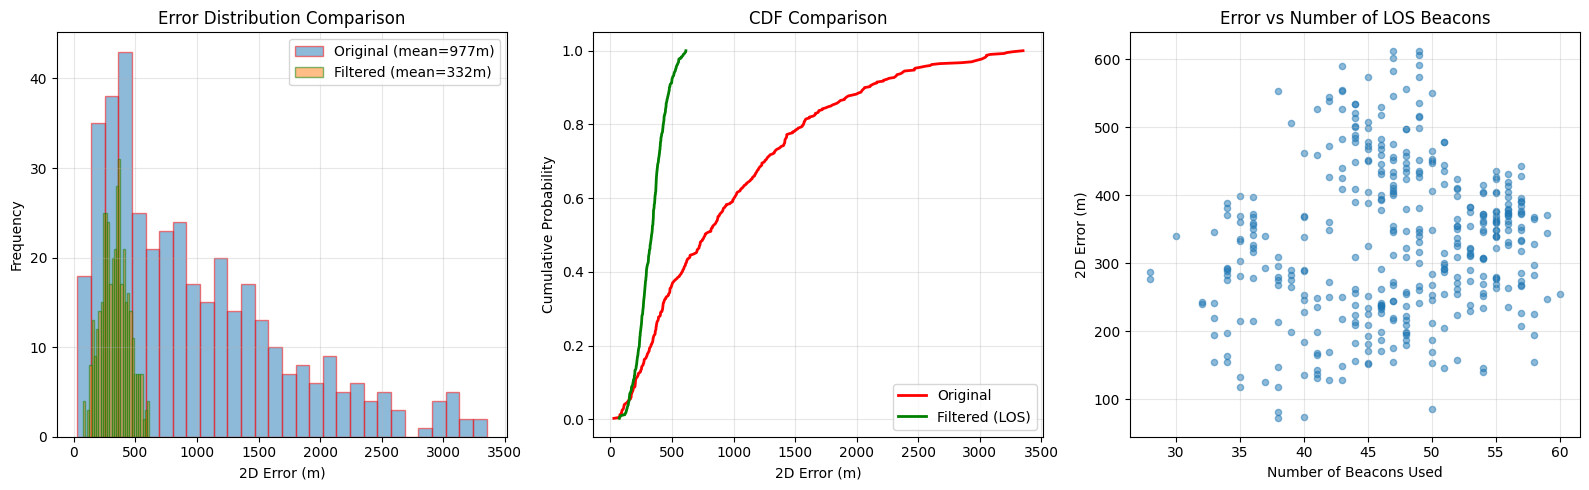

In [48]:
# Compare results: Original vs Filtered
print("="*70)
print("COMPARISON: Original (All Signals) vs Filtered (LOS-only)")
print("="*70)
print(f"\n{'Metric':<30} {'Original':>18} {'Filtered (LOS)':>18}")
print("-"*70)
print(f"{'Mean 2D Error (m)':<30} {errors_2d.mean():>18.2f} {np.nanmean(valid_errors_2d):>18.2f}")
print(f"{'Median 2D Error (m)':<30} {np.median(errors_2d):>18.2f} {np.nanmedian(valid_errors_2d):>18.2f}")
print(f"{'Std 2D Error (m)':<30} {errors_2d.std():>18.2f} {np.nanstd(valid_errors_2d):>18.2f}")
print(f"{'Min 2D Error (m)':<30} {errors_2d.min():>18.2f} {np.nanmin(valid_errors_2d):>18.2f}")
print(f"{'Max 2D Error (m)':<30} {errors_2d.max():>18.2f} {np.nanmax(valid_errors_2d):>18.2f}")
print("-"*70)
print(f"{'Positions Localized':<30} {num_drone_positions:>18} {len(valid_errors_2d):>18}")
print(f"{'Avg Beacons Used':<30} {num_beacons:>18} {num_beacons_used[num_beacons_used >= 4].mean():>18.1f}")
print("="*70)

improvement = (errors_2d.mean() - np.nanmean(valid_errors_2d)) / errors_2d.mean() * 100
print(f"\n>>> IMPROVEMENT: {improvement:.1f}% reduction in mean error <<<")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Histogram comparison
ax1 = axes[0]
ax1.hist(errors_2d, bins=30, alpha=0.5, label=f'Original (mean={errors_2d.mean():.0f}m)', edgecolor='red')
ax1.hist(valid_errors_2d, bins=30, alpha=0.5, label=f'Filtered (mean={np.nanmean(valid_errors_2d):.0f}m)', edgecolor='green')
ax1.set_xlabel('2D Error (m)')
ax1.set_ylabel('Frequency')
ax1.set_title('Error Distribution Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# CDF comparison
ax2 = axes[1]
sorted_orig = np.sort(errors_2d)
sorted_filt = np.sort(valid_errors_2d)
ax2.plot(sorted_orig, np.arange(1, len(sorted_orig)+1)/len(sorted_orig), 
         'r-', linewidth=2, label='Original')
ax2.plot(sorted_filt, np.arange(1, len(sorted_filt)+1)/len(sorted_filt), 
         'g-', linewidth=2, label='Filtered (LOS)')
ax2.set_xlabel('2D Error (m)')
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('CDF Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Error vs number of beacons used
ax3 = axes[2]
valid_idx = ~np.isnan(errors_2d_filtered)
ax3.scatter(num_beacons_used[valid_idx], errors_2d_filtered[valid_idx], alpha=0.5, s=20)
ax3.set_xlabel('Number of Beacons Used')
ax3.set_ylabel('2D Error (m)')
ax3.set_title('Error vs Number of LOS Beacons')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('filtered_vs_original_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 2.7 Top-K Strongest RSSI Approach (Like Paper)

Use only the **K strongest RSSI signals** for multilateration, consistent with the paper which used 10 beacons.

This approach:
- Automatically selects best LOS signals
- Matches paper methodology
- More practical for real deployments


In [49]:
def multilaterate_top_k(beacon_locations_all, rssi_values, target_altitude, 
                         k=10, delta=10.0, model_A=None, model_n=None):
    """
    Multilateration using only the K strongest RSSI signals.
    
    Parameters:
    -----------
    k : int
        Number of strongest signals to use (default: 10, matching paper)
    model_A, model_n : float
        RSSI-to-distance model parameters (uses LOS model if None)
    """
    if model_A is None:
        model_A = A_fit_los
    if model_n is None:
        model_n = n_fit_los
    
    # Get indices of top K strongest RSSI values
    top_k_indices = np.argsort(rssi_values)[-k:]  # Highest RSSI = strongest signal
    
    # Get top K beacons and their RSSI
    top_k_beacon_locs = [beacon_locations_all[i] for i in top_k_indices]
    top_k_rssi = rssi_values[top_k_indices]
    
    # Convert RSSI to distance
    estimated_distances = rssi_to_distance(top_k_rssi, model_A, model_n)
    
    # Run multilateration
    estimated_pos, loss = multilaterate(
        top_k_beacon_locs,
        estimated_distances,
        target_altitude,
        delta=delta,
        use_altitude_constraint=True
    )
    
    return estimated_pos, loss, top_k_rssi.min()  # Return min RSSI of used beacons

# Run Top-K localization for different K values
K_VALUES = [4, 6, 8, 10, 15, 20]
results_by_k = {}

for k in K_VALUES:
    print(f"\nRunning Top-{k} strongest RSSI multilateration...")
    
    errors_2d_topk = []
    min_rssi_used = []
    
    for i in tqdm(range(num_drone_positions)):
        rssi_values = rssi_matrix[i, :]
        
        estimated_pos, loss, min_rssi = multilaterate_top_k(
            beacon_locations, 
            rssi_values, 
            drone_altitude,
            k=k,
            delta=10.0
        )
        
        # Calculate 2D error
        true_pos_2d = to_cartesian_2d(drone_lat[i], drone_lon[i])
        est_pos_2d = to_cartesian_2d(estimated_pos[0], estimated_pos[1])
        errors_2d_topk.append(np.linalg.norm(true_pos_2d - est_pos_2d))
        min_rssi_used.append(min_rssi)
    
    errors_2d_topk = np.array(errors_2d_topk)
    min_rssi_used = np.array(min_rssi_used)
    
    results_by_k[k] = {
        'errors_2d': errors_2d_topk,
        'mean': errors_2d_topk.mean(),
        'median': np.median(errors_2d_topk),
        'std': errors_2d_topk.std(),
        'min_rssi_mean': min_rssi_used.mean()
    }
    
    print(f"  Top-{k}: Mean={errors_2d_topk.mean():.1f}m, Median={np.median(errors_2d_topk):.1f}m, "
          f"Min RSSI used (avg): {min_rssi_used.mean():.1f} dBm")



Running Top-4 strongest RSSI multilateration...


100%|██████████| 400/400 [00:02<00:00, 134.21it/s]


  Top-4: Mean=122.4m, Median=90.7m, Min RSSI used (avg): -73.7 dBm

Running Top-6 strongest RSSI multilateration...


100%|██████████| 400/400 [00:02<00:00, 146.10it/s]


  Top-6: Mean=125.4m, Median=99.1m, Min RSSI used (avg): -76.5 dBm

Running Top-8 strongest RSSI multilateration...


100%|██████████| 400/400 [00:02<00:00, 150.29it/s]


  Top-8: Mean=127.9m, Median=106.9m, Min RSSI used (avg): -78.4 dBm

Running Top-10 strongest RSSI multilateration...


100%|██████████| 400/400 [00:02<00:00, 141.69it/s]


  Top-10: Mean=125.9m, Median=116.2m, Min RSSI used (avg): -79.8 dBm

Running Top-15 strongest RSSI multilateration...


100%|██████████| 400/400 [00:02<00:00, 152.18it/s]


  Top-15: Mean=151.6m, Median=146.1m, Min RSSI used (avg): -82.4 dBm

Running Top-20 strongest RSSI multilateration...


100%|██████████| 400/400 [00:02<00:00, 150.95it/s]

  Top-20: Mean=194.7m, Median=179.4m, Min RSSI used (avg): -84.1 dBm


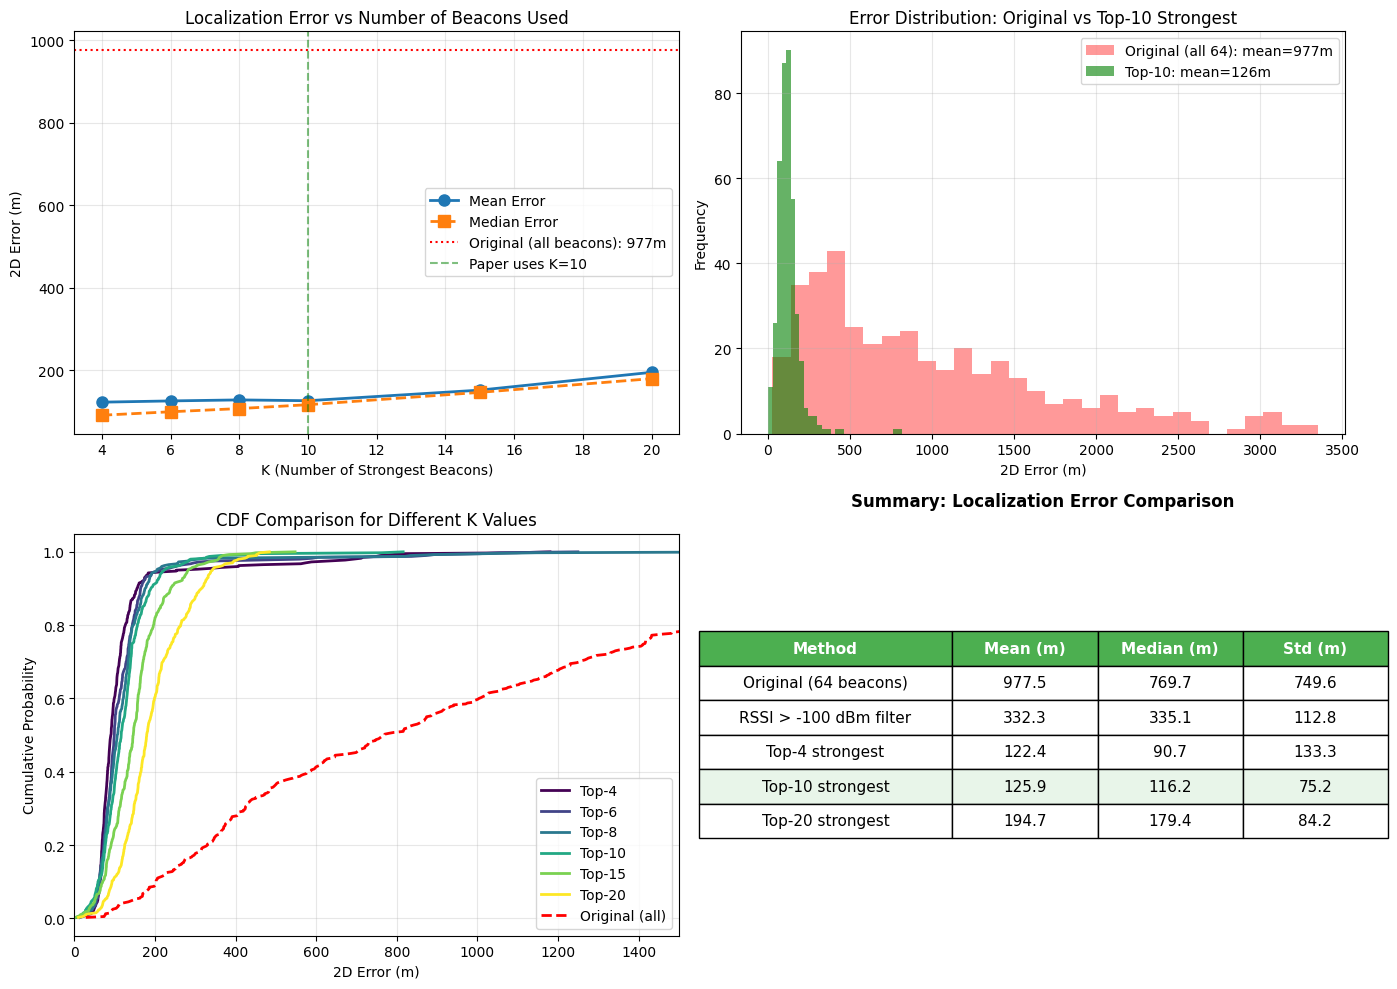


TOP-10 STRONGEST RSSI RESULTS (Matching Paper Methodology)
Mean 2D Error:   125.87 m
Median 2D Error: 116.22 m
Std 2D Error:    75.18 m
Min Error:       3.64 m
Max Error:       815.68 m

Percentiles:
  50th: 116.2 m
  75th: 144.0 m
  90th: 189.8 m
  95th: 222.1 m


In [50]:
# Visualize Top-K results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Mean/Median error vs K
ax1 = axes[0, 0]
ks = list(results_by_k.keys())
means = [results_by_k[k]['mean'] for k in ks]
medians = [results_by_k[k]['median'] for k in ks]
ax1.plot(ks, means, 'o-', linewidth=2, markersize=8, label='Mean Error')
ax1.plot(ks, medians, 's--', linewidth=2, markersize=8, label='Median Error')
ax1.axhline(errors_2d.mean(), color='r', linestyle=':', label=f'Original (all beacons): {errors_2d.mean():.0f}m')
ax1.axvline(10, color='g', linestyle='--', alpha=0.5, label='Paper uses K=10')
ax1.set_xlabel('K (Number of Strongest Beacons)')
ax1.set_ylabel('2D Error (m)')
ax1.set_title('Localization Error vs Number of Beacons Used')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Error distribution comparison (Original vs Top-10)
ax2 = axes[0, 1]
ax2.hist(errors_2d, bins=30, alpha=0.4, label=f'Original (all 64): mean={errors_2d.mean():.0f}m', color='red')
ax2.hist(results_by_k[10]['errors_2d'], bins=30, alpha=0.6, label=f'Top-10: mean={results_by_k[10]["mean"]:.0f}m', color='green')
ax2.set_xlabel('2D Error (m)')
ax2.set_ylabel('Frequency')
ax2.set_title('Error Distribution: Original vs Top-10 Strongest')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: CDF comparison for multiple K values
ax3 = axes[1, 0]
colors = plt.cm.viridis(np.linspace(0, 1, len(K_VALUES)))
for i, k in enumerate(K_VALUES):
    sorted_errors = np.sort(results_by_k[k]['errors_2d'])
    cdf = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
    ax3.plot(sorted_errors, cdf, linewidth=2, color=colors[i], label=f'Top-{k}')
# Add original
sorted_orig = np.sort(errors_2d)
ax3.plot(sorted_orig, np.arange(1, len(sorted_orig)+1)/len(sorted_orig), 
         'r--', linewidth=2, label='Original (all)')
ax3.set_xlabel('2D Error (m)')
ax3.set_ylabel('Cumulative Probability')
ax3.set_title('CDF Comparison for Different K Values')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 1500])

# Plot 4: Summary table
ax4 = axes[1, 1]
ax4.axis('off')
table_data = [['Method', 'Mean (m)', 'Median (m)', 'Std (m)']]
table_data.append(['Original (64 beacons)', f'{errors_2d.mean():.1f}', f'{np.median(errors_2d):.1f}', f'{errors_2d.std():.1f}'])
table_data.append(['RSSI > -100 dBm filter', f'{np.nanmean(valid_errors_2d):.1f}', f'{np.nanmedian(valid_errors_2d):.1f}', f'{np.nanstd(valid_errors_2d):.1f}'])
for k in [4, 10, 20]:
    table_data.append([f'Top-{k} strongest', f'{results_by_k[k]["mean"]:.1f}', f'{results_by_k[k]["median"]:.1f}', f'{results_by_k[k]["std"]:.1f}'])

table = ax4.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[0.35, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Highlight header row
for j in range(4):
    table[(0, j)].set_facecolor('#4CAF50')
    table[(0, j)].set_text_props(color='white', fontweight='bold')
# Highlight Top-10 row (paper method)
for j in range(4):
    table[(4, j)].set_facecolor('#E8F5E9')

ax4.set_title('Summary: Localization Error Comparison', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('top_k_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print detailed Top-10 results (matching paper)
print("\n" + "="*70)
print("TOP-10 STRONGEST RSSI RESULTS (Matching Paper Methodology)")
print("="*70)
print(f"Mean 2D Error:   {results_by_k[10]['mean']:.2f} m")
print(f"Median 2D Error: {results_by_k[10]['median']:.2f} m")
print(f"Std 2D Error:    {results_by_k[10]['std']:.2f} m")
print(f"Min Error:       {results_by_k[10]['errors_2d'].min():.2f} m")
print(f"Max Error:       {results_by_k[10]['errors_2d'].max():.2f} m")
print(f"\nPercentiles:")
for p in [50, 75, 90, 95]:
    print(f"  {p}th: {np.percentile(results_by_k[10]['errors_2d'], p):.1f} m")
print("="*70)


Generating Top-10 estimated positions for visualization...


100%|██████████| 400/400 [00:03<00:00, 132.08it/s]


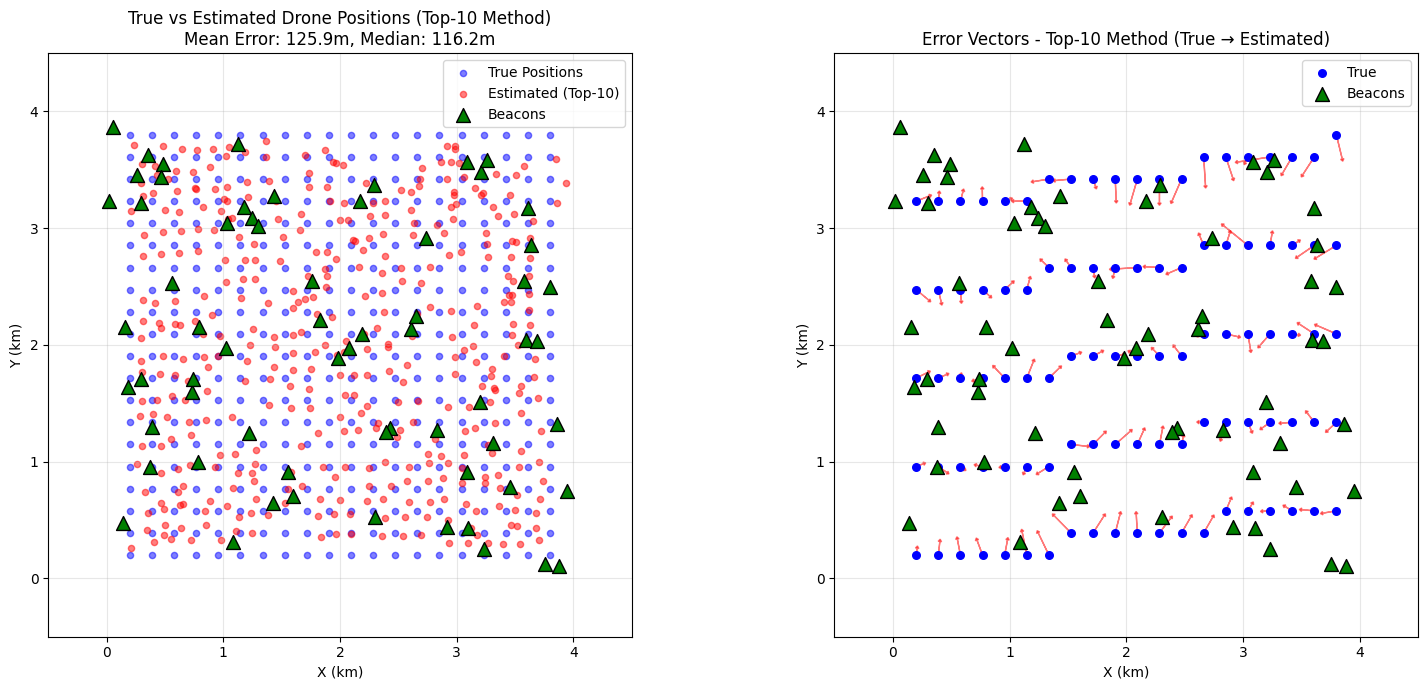

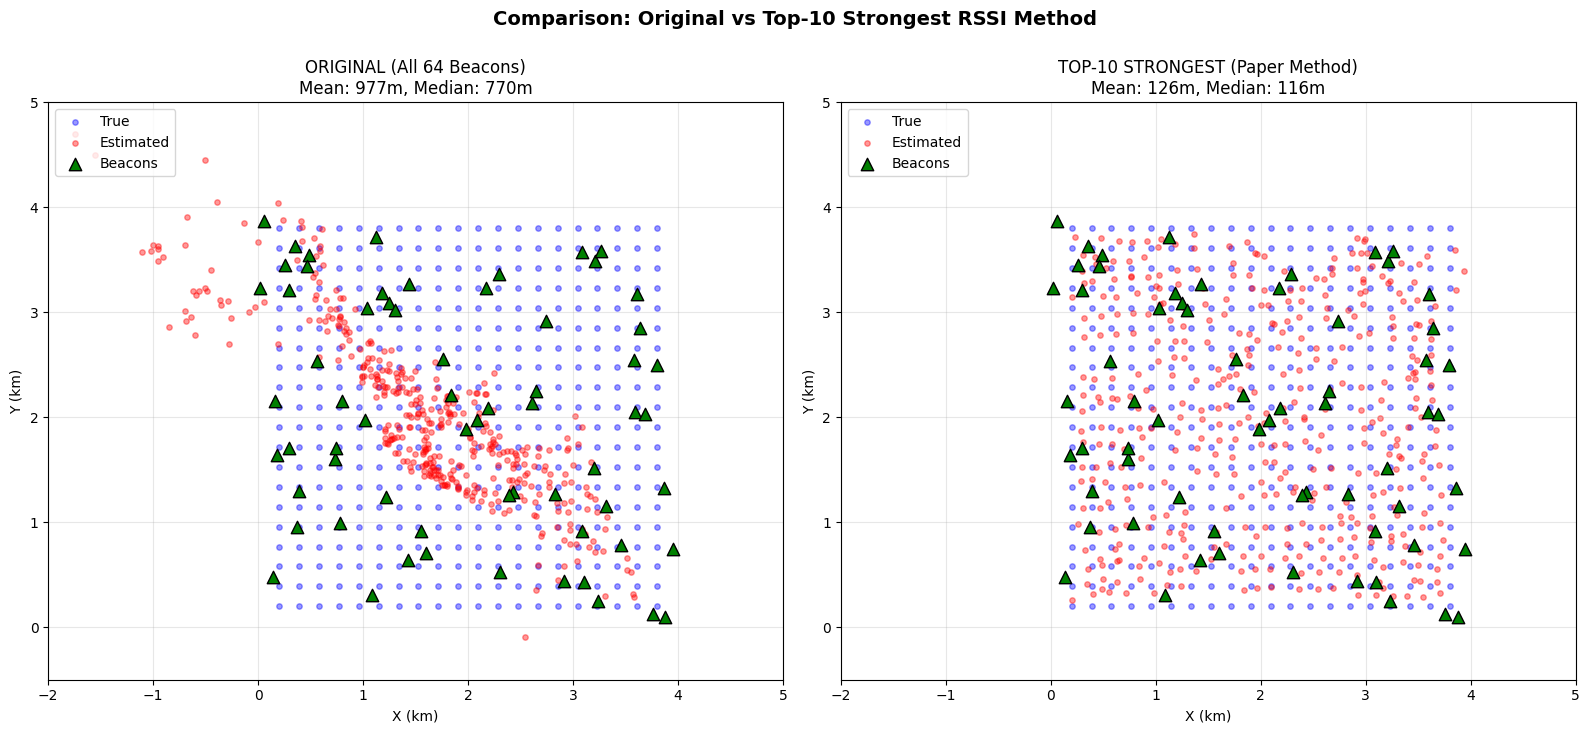


>>> Top-10 method reduces error by 87% <<<


In [63]:
# Generate estimated positions for Top-10 method for visualization
print("Generating Top-10 estimated positions for visualization...")

estimated_positions_top10 = []
for i in tqdm(range(num_drone_positions)):
    rssi_values = rssi_matrix[i, :]
    estimated_pos, _, _ = multilaterate_top_k(
        beacon_locations, 
        rssi_values, 
        drone_altitude,
        k=10,
        delta=10.0
    )
    estimated_positions_top10.append(estimated_pos)

# Convert to meters
estimated_x_top10 = np.array([(pos[1] - map_origin_lon) / deg_per_meter_lon for pos in estimated_positions_top10])
estimated_y_top10 = np.array([(pos[0] - map_origin_lat) / deg_per_meter_lat for pos in estimated_positions_top10])

# Visualize Top-10 results
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: All positions (Top-10)
ax1 = axes[0]
ax1.scatter(drone_x/1000, drone_y/1000, c='blue', s=20, alpha=0.5, label='True Positions')
ax1.scatter(estimated_x_top10/1000, estimated_y_top10/1000, c='red', s=20, alpha=0.5, label='Estimated (Top-10)')
ax1.scatter(beacon_x/1000, beacon_y/1000, c='green', s=100, marker='^', 
            label='Beacons', zorder=5, edgecolors='black')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.set_title(f'True vs Estimated Drone Positions (Top-10 Method)\nMean Error: {results_by_k[10]["mean"]:.1f}m, Median: {results_by_k[10]["median"]:.1f}m')
ax1.legend()
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([-0.5, 4.5])
ax1.set_ylim([-0.5, 4.5])

# Plot 2: Error vectors for sample points (Top-10)
ax2 = axes[1]
sample_indices = np.linspace(0, num_drone_positions-1, 100, dtype=int)

for idx in sample_indices:
    ax2.arrow(drone_x[idx]/1000, drone_y[idx]/1000,
              (estimated_x_top10[idx] - drone_x[idx])/1000,
              (estimated_y_top10[idx] - drone_y[idx])/1000,
              head_width=0.03, head_length=0.02, fc='red', ec='red', alpha=0.5)

ax2.scatter(drone_x[sample_indices]/1000, drone_y[sample_indices]/1000, 
            c='blue', s=30, label='True', zorder=3)
ax2.scatter(beacon_x/1000, beacon_y/1000, c='green', s=100, marker='^', 
            label='Beacons', zorder=5, edgecolors='black')
ax2.set_xlabel('X (km)')
ax2.set_ylabel('Y (km)')
ax2.set_title('Error Vectors - Top-10 Method (True → Estimated)')
ax2.legend()
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([-0.5, 4.5])
ax2.set_ylim([-0.5, 4.5])

plt.tight_layout()
plt.savefig('top10_position_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Side-by-side comparison: Original vs Top-10
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Original method
ax1 = axes[0]
ax1.scatter(drone_x/1000, drone_y/1000, c='blue', s=15, alpha=0.4, label='True')
ax1.scatter(estimated_x/1000, estimated_y/1000, c='red', s=15, alpha=0.4, label='Estimated')
ax1.scatter(beacon_x/1000, beacon_y/1000, c='green', s=80, marker='^', 
            label='Beacons', zorder=5, edgecolors='black')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.set_title(f'ORIGINAL (All 64 Beacons)\nMean: {errors_2d.mean():.0f}m, Median: {np.median(errors_2d):.0f}m')
ax1.legend(loc='upper left')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([-2, 5])
ax1.set_ylim([-0.5, 5])

# Top-10 method
ax2 = axes[1]
ax2.scatter(drone_x/1000, drone_y/1000, c='blue', s=15, alpha=0.4, label='True')
ax2.scatter(estimated_x_top10/1000, estimated_y_top10/1000, c='red', s=15, alpha=0.4, label='Estimated')
ax2.scatter(beacon_x/1000, beacon_y/1000, c='green', s=80, marker='^', 
            label='Beacons', zorder=5, edgecolors='black')
ax2.set_xlabel('X (km)')
ax2.set_ylabel('Y (km)')
ax2.set_title(f'TOP-10 STRONGEST (Paper Method)\nMean: {results_by_k[10]["mean"]:.0f}m, Median: {results_by_k[10]["median"]:.0f}m')
ax2.legend(loc='upper left')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([-2, 5])
ax2.set_ylim([-0.5, 5])

plt.suptitle('Comparison: Original vs Top-10 Strongest RSSI Method', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('original_vs_top10_positions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n>>> Top-10 method reduces error by {(1 - results_by_k[10]['mean']/errors_2d.mean())*100:.0f}% <<<")


## 2.8 Beacon Location Noise Study (Top-K Method)

Test how beacon position uncertainty affects localization accuracy using the Top-10 method.

This is the core research question: **How does error in beacon location knowledge impact drone localization?**


In [68]:
def run_top_k_with_beacon_noise(noise_std_meters, k=10, num_trials=3):
    """
    Run Top-K multilateration with noisy beacon locations.
    
    Parameters:
    -----------
    noise_std_meters : float
        Standard deviation of Gaussian noise added to beacon X/Y positions (meters)
    k : int
        Number of strongest signals to use
    num_trials : int
        Number of trials to average over (for stochastic noise)
    
    Returns:
    --------
    dict : Results including mean/median 2D errors
    """
    all_errors_2d = []
    
    for trial in range(num_trials):
        # Add noise to beacon positions
        noisy_beacon_x = beacon_x + np.random.normal(0, noise_std_meters, num_beacons)
        noisy_beacon_y = beacon_y + np.random.normal(0, noise_std_meters, num_beacons)
        
        # Convert noisy positions to lat/lon
        noisy_beacon_lat = map_origin_lat + noisy_beacon_y * deg_per_meter_lat
        noisy_beacon_lon = map_origin_lon + noisy_beacon_x * deg_per_meter_lon
        
        # Create noisy beacon locations
        noisy_beacon_locations = [(noisy_beacon_lat[i], noisy_beacon_lon[i], beacon_height) 
                                   for i in range(num_beacons)]
        
        errors_2d_trial = []
        
        for i in range(num_drone_positions):
            rssi_values = rssi_matrix[i, :]
            
            # Get indices of top K strongest RSSI values
            top_k_indices = np.argsort(rssi_values)[-k:]
            
            # Get top K noisy beacon locations and their RSSI
            top_k_beacon_locs = [noisy_beacon_locations[idx] for idx in top_k_indices]
            top_k_rssi = rssi_values[top_k_indices]
            
            # Convert RSSI to distance
            estimated_distances = rssi_to_distance(top_k_rssi, A_fit_los, n_fit_los)
            
            # Run multilateration with noisy beacon locations
            estimated_pos, _ = multilaterate(
                top_k_beacon_locs,
                estimated_distances,
                drone_altitude,
                delta=10.0,
                use_altitude_constraint=True
            )
            
            # Calculate error against TRUE drone position
            true_pos_2d = to_cartesian_2d(drone_lat[i], drone_lon[i])
            est_pos_2d = to_cartesian_2d(estimated_pos[0], estimated_pos[1])
            errors_2d_trial.append(np.linalg.norm(true_pos_2d - est_pos_2d))
        
        all_errors_2d.append(np.array(errors_2d_trial))
    
    # Average across trials
    avg_errors_2d = np.mean(all_errors_2d, axis=0)
    
    return {
        'noise_std': noise_std_meters,
        'mean_2d': np.mean(avg_errors_2d),
        'median_2d': np.median(avg_errors_2d),
        'std_2d': np.std(avg_errors_2d),
        'p90_2d': np.percentile(avg_errors_2d, 90),
        'errors_2d': avg_errors_2d
    }

# Test different noise levels
NOISE_LEVELS = [0, 5, 10, 25, 50, 100, 150, 200]  # meters
K_TO_TEST = 10  # Use Top-10 (paper method)
NUM_TRIALS = 3  # Average over 3 random noise realizations

noise_results_topk = []

print(f"Running beacon noise study with Top-{K_TO_TEST} method...")
print(f"Averaging over {NUM_TRIALS} trials per noise level\n")

for noise_std in NOISE_LEVELS:
    print(f"Testing noise σ = {noise_std} m...")
    result = run_top_k_with_beacon_noise(noise_std, k=K_TO_TEST, num_trials=NUM_TRIALS)
    noise_results_topk.append(result)
    print(f"  → Mean: {result['mean_2d']:.1f} m, Median: {result['median_2d']:.1f} m, 90th: {result['p90_2d']:.1f} m")

print("\nBeacon noise study complete!")


Running beacon noise study with Top-10 method...
Averaging over 3 trials per noise level

Testing noise σ = 0 m...
  → Mean: 125.9 m, Median: 116.2 m, 90th: 189.8 m
Testing noise σ = 5 m...
  → Mean: 128.7 m, Median: 116.1 m, 90th: 189.5 m
Testing noise σ = 10 m...
  → Mean: 129.3 m, Median: 116.2 m, 90th: 191.2 m
Testing noise σ = 25 m...
  → Mean: 128.5 m, Median: 116.3 m, 90th: 200.4 m
Testing noise σ = 50 m...
  → Mean: 122.7 m, Median: 107.4 m, 90th: 197.5 m
Testing noise σ = 100 m...
  → Mean: 139.7 m, Median: 112.7 m, 90th: 240.0 m
Testing noise σ = 150 m...
  → Mean: 158.1 m, Median: 138.0 m, 90th: 250.1 m
Testing noise σ = 200 m...
  → Mean: 194.2 m, Median: 166.2 m, 90th: 285.7 m

Beacon noise study complete!


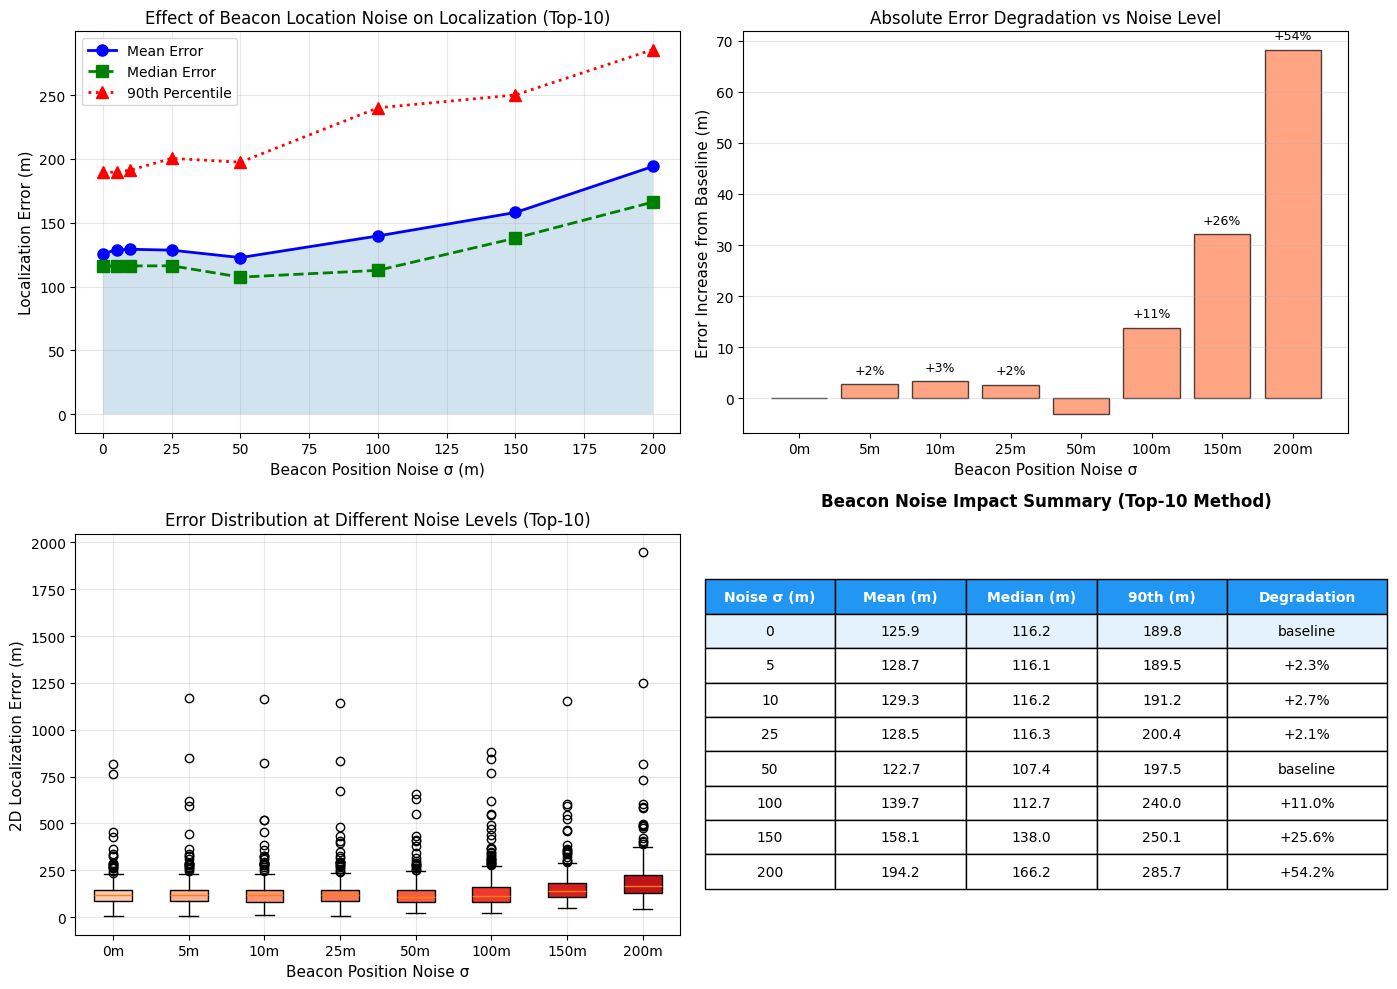


BEACON LOCATION NOISE STUDY RESULTS (Top-10 Method)

Baseline (no noise): Mean=125.9m, Median=116.2m

Error increase with beacon position noise:
  σ=  5m → Mean=128.7m (+2.8m, +2.3%)
  σ= 10m → Mean=129.3m (+3.4m, +2.7%)
  σ= 25m → Mean=128.5m (+2.7m, +2.1%)
  σ= 50m → Mean=122.7m (+-3.1m, +-2.5%)
  σ=100m → Mean=139.7m (+13.8m, +11.0%)
  σ=150m → Mean=158.1m (+32.2m, +25.6%)
  σ=200m → Mean=194.2m (+68.3m, +54.2%)


In [69]:
# Visualize beacon noise study results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Extract data
noise_stds = [r['noise_std'] for r in noise_results_topk]
mean_errors = [r['mean_2d'] for r in noise_results_topk]
median_errors = [r['median_2d'] for r in noise_results_topk]
p90_errors = [r['p90_2d'] for r in noise_results_topk]

# Plot 1: Error vs Noise Level
ax1 = axes[0, 0]
ax1.plot(noise_stds, mean_errors, 'o-', linewidth=2, markersize=8, label='Mean Error', color='blue')
ax1.plot(noise_stds, median_errors, 's--', linewidth=2, markersize=8, label='Median Error', color='green')
ax1.plot(noise_stds, p90_errors, '^:', linewidth=2, markersize=8, label='90th Percentile', color='red')
ax1.fill_between(noise_stds, mean_errors, alpha=0.2)
ax1.set_xlabel('Beacon Position Noise σ (m)', fontsize=11)
ax1.set_ylabel('Localization Error (m)', fontsize=11)
ax1.set_title('Effect of Beacon Location Noise on Localization (Top-10)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Error degradation ratio
ax2 = axes[0, 1]
baseline_mean = noise_results_topk[0]['mean_2d']
baseline_median = noise_results_topk[0]['median_2d']
degradation_mean = [(r['mean_2d'] - baseline_mean) for r in noise_results_topk]
degradation_pct = [(r['mean_2d'] / baseline_mean - 1) * 100 for r in noise_results_topk]

ax2.bar(range(len(noise_stds)), degradation_mean, tick_label=[f'{n}m' for n in noise_stds], 
        color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Beacon Position Noise σ', fontsize=11)
ax2.set_ylabel('Error Increase from Baseline (m)', fontsize=11)
ax2.set_title('Absolute Error Degradation vs Noise Level', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for i, (deg, pct) in enumerate(zip(degradation_mean, degradation_pct)):
    if deg > 0:
        ax2.text(i, deg + 2, f'+{pct:.0f}%', ha='center', fontsize=9)

# Plot 3: Box plots
ax3 = axes[1, 0]
boxplot_data = [r['errors_2d'] for r in noise_results_topk]
bp = ax3.boxplot(boxplot_data, labels=[f'{n}m' for n in noise_stds], patch_artist=True)
colors = plt.cm.Reds(np.linspace(0.2, 0.8, len(noise_stds)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax3.set_xlabel('Beacon Position Noise σ', fontsize=11)
ax3.set_ylabel('2D Localization Error (m)', fontsize=11)
ax3.set_title('Error Distribution at Different Noise Levels (Top-10)', fontsize=12)
ax3.grid(True, alpha=0.3)

# Plot 4: Summary table
ax4 = axes[1, 1]
ax4.axis('off')
table_data = [['Noise σ (m)', 'Mean (m)', 'Median (m)', '90th (m)', 'Degradation']]
for r in noise_results_topk:
    deg_pct = (r['mean_2d'] / baseline_mean - 1) * 100
    deg_str = f"+{deg_pct:.1f}%" if deg_pct > 0 else "baseline"
    table_data.append([
        f"{r['noise_std']}", 
        f"{r['mean_2d']:.1f}", 
        f"{r['median_2d']:.1f}",
        f"{r['p90_2d']:.1f}",
        deg_str
    ])

table = ax4.table(cellText=table_data, loc='center', cellLoc='center', 
                   colWidths=[0.18, 0.18, 0.18, 0.18, 0.22])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.8)

# Style header
for j in range(5):
    table[(0, j)].set_facecolor('#2196F3')
    table[(0, j)].set_text_props(color='white', fontweight='bold')
# Highlight baseline row
for j in range(5):
    table[(1, j)].set_facecolor('#E3F2FD')

ax4.set_title('Beacon Noise Impact Summary (Top-10 Method)', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('beacon_noise_study_top10.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*70)
print("BEACON LOCATION NOISE STUDY RESULTS (Top-10 Method)")
print("="*70)
print(f"\nBaseline (no noise): Mean={baseline_mean:.1f}m, Median={baseline_median:.1f}m")
print("\nError increase with beacon position noise:")
for r in noise_results_topk[1:]:
    deg = r['mean_2d'] - baseline_mean
    pct = (r['mean_2d'] / baseline_mean - 1) * 100
    print(f"  σ={r['noise_std']:3d}m → Mean={r['mean_2d']:.1f}m (+{deg:.1f}m, +{pct:.1f}%)")
print("="*70)


Comparing robustness to beacon noise across different K values...

Testing K=4...
  Noise σ=0m → Mean=122.4m
  Noise σ=10m → Mean=118.0m
  Noise σ=50m → Mean=133.8m
  Noise σ=100m → Mean=165.4m

Testing K=10...
  Noise σ=0m → Mean=125.9m
  Noise σ=10m → Mean=127.6m
  Noise σ=50m → Mean=124.7m
  Noise σ=100m → Mean=144.7m

Testing K=20...
  Noise σ=0m → Mean=194.7m
  Noise σ=10m → Mean=194.4m
  Noise σ=50m → Mean=184.8m
  Noise σ=100m → Mean=181.4m


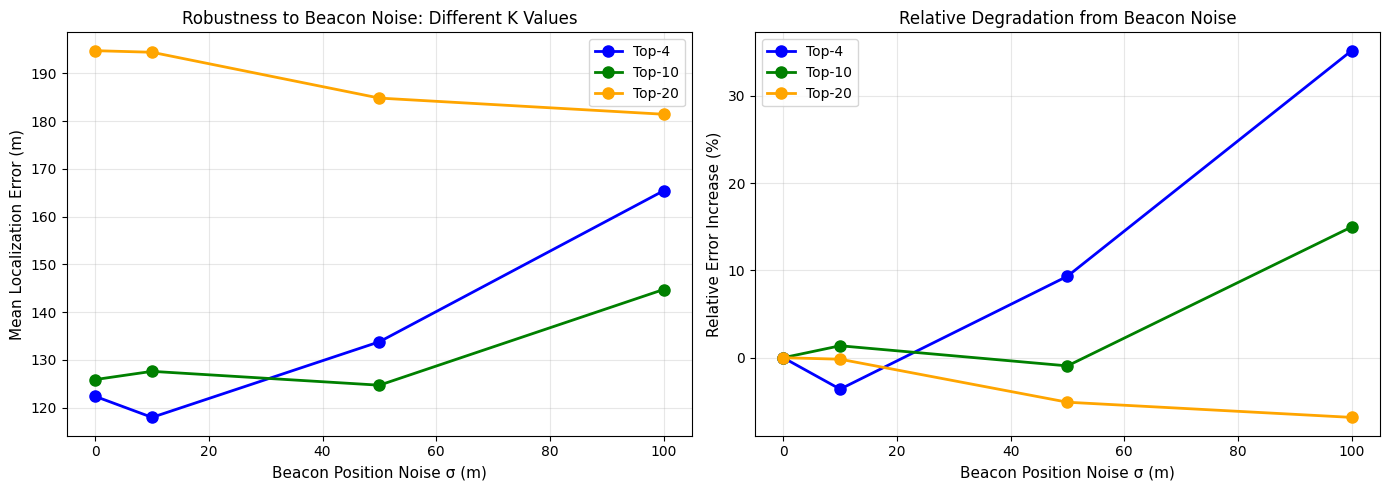


BEACON NOISE ROBUSTNESS COMPARISON

K        Baseline     σ=10m        σ=50m        σ=100m      
----------------------------------------------------------------------
Top-4    122.4m       118.0m       133.8m       165.4m      
Top-10   125.9m       127.6m       124.7m       144.7m      
Top-20   194.7m       194.4m       184.8m       181.4m      


In [66]:
# Compare how different K values handle beacon noise
print("Comparing robustness to beacon noise across different K values...")

K_VALUES_NOISE = [4, 10, 20]
NOISE_LEVELS_COMPARE = [0, 10, 50, 100]

robustness_results = {}

for k in K_VALUES_NOISE:
    robustness_results[k] = []
    print(f"\nTesting K={k}...")
    for noise_std in NOISE_LEVELS_COMPARE:
        result = run_top_k_with_beacon_noise(noise_std, k=k, num_trials=2)
        robustness_results[k].append(result)
        print(f"  Noise σ={noise_std}m → Mean={result['mean_2d']:.1f}m")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Mean error vs noise for different K
ax1 = axes[0]
colors = ['blue', 'green', 'orange']
for i, k in enumerate(K_VALUES_NOISE):
    noise_vals = [r['noise_std'] for r in robustness_results[k]]
    mean_vals = [r['mean_2d'] for r in robustness_results[k]]
    ax1.plot(noise_vals, mean_vals, 'o-', linewidth=2, markersize=8, 
             label=f'Top-{k}', color=colors[i])

ax1.set_xlabel('Beacon Position Noise σ (m)', fontsize=11)
ax1.set_ylabel('Mean Localization Error (m)', fontsize=11)
ax1.set_title('Robustness to Beacon Noise: Different K Values', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Relative degradation
ax2 = axes[1]
for i, k in enumerate(K_VALUES_NOISE):
    baseline = robustness_results[k][0]['mean_2d']
    noise_vals = [r['noise_std'] for r in robustness_results[k]]
    rel_increase = [(r['mean_2d'] / baseline - 1) * 100 for r in robustness_results[k]]
    ax2.plot(noise_vals, rel_increase, 'o-', linewidth=2, markersize=8, 
             label=f'Top-{k}', color=colors[i])

ax2.set_xlabel('Beacon Position Noise σ (m)', fontsize=11)
ax2.set_ylabel('Relative Error Increase (%)', fontsize=11)
ax2.set_title('Relative Degradation from Beacon Noise', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('beacon_noise_k_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary
print("\n" + "="*70)
print("BEACON NOISE ROBUSTNESS COMPARISON")
print("="*70)
print(f"\n{'K':<8} {'Baseline':<12} {'σ=10m':<12} {'σ=50m':<12} {'σ=100m':<12}")
print("-"*70)
for k in K_VALUES_NOISE:
    baseline = robustness_results[k][0]['mean_2d']
    vals = [f"{r['mean_2d']:.1f}m" for r in robustness_results[k]]
    print(f"Top-{k:<4} {vals[0]:<12} {vals[1]:<12} {vals[2]:<12} {vals[3]:<12}")
print("="*70)


NOISE STATISTICS CLARIFICATION

When we add Gaussian noise with σ to beacon positions:

    noisy_x = true_x + N(0, σ²)
    noisy_y = true_y + N(0, σ²)

The 2D position error = √(noise_x² + noise_y²) follows a RAYLEIGH distribution!

THEORETICAL vs EMPIRICAL VERIFICATION:
----------------------------------------------------------------------
Noise σ      Theory Mean    Empirical Mean   Theory Median  Empirical Med 
----------------------------------------------------------------------
     0m          0.0m            0.0m          0.0m          0.0m
     5m          6.3m            6.2m          5.9m          5.9m
    10m         12.5m           12.5m         11.8m         11.7m
    25m         31.3m           31.2m         29.4m         29.3m
    50m         62.7m           62.1m         58.9m         58.5m
   100m        125.3m          126.0m        117.7m        118.4m
   150m        188.0m          189.2m        176.6m        178.3m
   200m        250.7m          248.7m        235

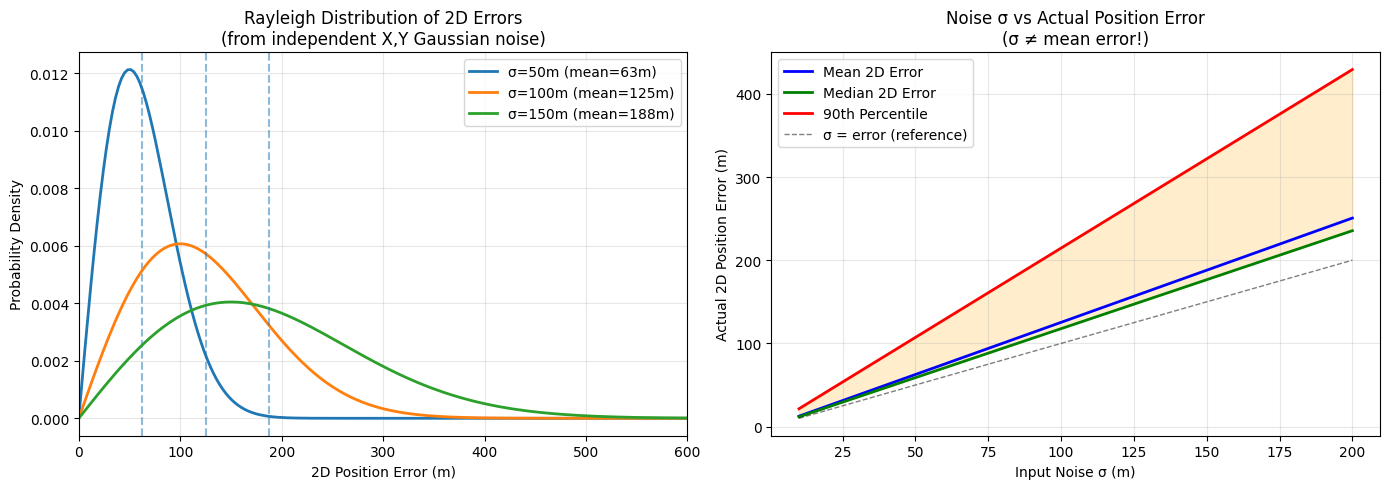


⚠️ IMPORTANT: When we say 'noise σ = 100m', the actual position errors are ~125m on average!


In [98]:
# Verify: What does "noise σ = X meters" actually mean?
print("="*70)
print("NOISE STATISTICS CLARIFICATION")
print("="*70)

print("""
When we add Gaussian noise with σ to beacon positions:

    noisy_x = true_x + N(0, σ²)
    noisy_y = true_y + N(0, σ²)

The 2D position error = √(noise_x² + noise_y²) follows a RAYLEIGH distribution!
""")

# Theoretical values
def rayleigh_stats(sigma):
    """Calculate statistics for 2D error from independent X,Y Gaussian noise"""
    mean = sigma * np.sqrt(np.pi / 2)
    median = sigma * np.sqrt(2 * np.log(2))
    p90 = sigma * np.sqrt(2 * np.log(10))
    return mean, median, p90

# Empirical verification
print("THEORETICAL vs EMPIRICAL VERIFICATION:")
print("-"*70)
print(f"{'Noise σ':<12} {'Theory Mean':<14} {'Empirical Mean':<16} {'Theory Median':<14} {'Empirical Med':<14}")
print("-"*70)

for sigma in [0, 5, 10, 25, 50, 100, 150, 200]:
    # Theoretical
    th_mean, th_median, th_p90 = rayleigh_stats(sigma)
    
    # Empirical (simulate 10000 samples)
    noise_x = np.random.normal(0, sigma, 10000)
    noise_y = np.random.normal(0, sigma, 10000)
    errors_2d = np.sqrt(noise_x**2 + noise_y**2)
    emp_mean = np.mean(errors_2d)
    emp_median = np.median(errors_2d)
    
    print(f"{sigma:>6}m {th_mean:>12.1f}m {emp_mean:>14.1f}m {th_median:>12.1f}m {emp_median:>12.1f}m")

print("-"*70)

# Show relationship
print("""
KEY RELATIONSHIPS:
─────────────────────────────────────────────────────────────────────
  Mean 2D Error   = σ × √(π/2)     ≈ σ × 1.253
  Median 2D Error = σ × √(2·ln2)   ≈ σ × 1.177  
  90th Percentile = σ × √(2·ln10)  ≈ σ × 2.146

So for σ = 100m:
  • Mean beacon position error   ≈ 125m
  • Median beacon position error ≈ 118m
  • 90% of errors are below      ≈ 215m
─────────────────────────────────────────────────────────────────────
""")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Rayleigh distribution for different σ
ax1 = axes[0]
x = np.linspace(0, 600, 200)
for sigma in [50, 100, 150]:
    # Rayleigh PDF
    pdf = (x / sigma**2) * np.exp(-x**2 / (2 * sigma**2))
    mean, median, _ = rayleigh_stats(sigma)
    ax1.plot(x, pdf, linewidth=2, label=f'σ={sigma}m (mean={mean:.0f}m)')
    ax1.axvline(mean, linestyle='--', alpha=0.5)

ax1.set_xlabel('2D Position Error (m)')
ax1.set_ylabel('Probability Density')
ax1.set_title('Rayleigh Distribution of 2D Errors\n(from independent X,Y Gaussian noise)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 600])

# Plot 2: σ vs actual error metrics
ax2 = axes[1]
sigmas = np.arange(10, 210, 10)
means = [rayleigh_stats(s)[0] for s in sigmas]
medians = [rayleigh_stats(s)[1] for s in sigmas]
p90s = [rayleigh_stats(s)[2] for s in sigmas]

ax2.plot(sigmas, means, 'b-', linewidth=2, label='Mean 2D Error')
ax2.plot(sigmas, medians, 'g-', linewidth=2, label='Median 2D Error')
ax2.plot(sigmas, p90s, 'r-', linewidth=2, label='90th Percentile')
ax2.plot(sigmas, sigmas, 'k--', linewidth=1, alpha=0.5, label='σ = error (reference)')
ax2.fill_between(sigmas, medians, p90s, alpha=0.2, color='orange')

ax2.set_xlabel('Input Noise σ (m)')
ax2.set_ylabel('Actual 2D Position Error (m)')
ax2.set_title('Noise σ vs Actual Position Error\n(σ ≠ mean error!)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('noise_statistics_clarification.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n⚠️ IMPORTANT: When we say 'noise σ = 100m', the actual position errors are ~125m on average!")


## 3. Drone Flight Simulation

Simulate a drone flying along a path using LoRa-based localization.

**Questions to answer:**
1. Can a drone navigate safely with these errors?
2. How does the estimated path compare to the true path?
3. What is the cross-track error (deviation from intended path)?


In [76]:
# Define a flight path across the map
# Simulate different flight patterns

def create_flight_path(pattern='diagonal', num_points=50):
    """Create flight path coordinates in meters"""
    t = np.linspace(0, 1, num_points)
    
    if pattern == 'diagonal':
        # Fly from corner to corner
        x = 500 + t * 3000  # 500m to 3500m
        y = 500 + t * 3000
    elif pattern == 'circular':
        # Circular path around center
        center_x, center_y = 2000, 2000
        radius = 1200
        theta = t * 2 * np.pi
        x = center_x + radius * np.cos(theta)
        y = center_y + radius * np.sin(theta)
    elif pattern == 'zigzag':
        # Zigzag pattern (delivery route simulation)
        x = 500 + t * 3000
        y = 1000 + 1000 * np.sin(t * 4 * np.pi) + t * 2000
    elif pattern == 'figure8':
        # Figure-8 pattern
        center_x, center_y = 2000, 2000
        theta = t * 2 * np.pi
        x = center_x + 1000 * np.sin(theta)
        y = center_y + 500 * np.sin(2 * theta)
    
    return x, y

def simulate_flight(path_x, path_y, k=10, beacon_noise_std=0):
    """
    Simulate drone flight along a path with LoRa localization.
    
    Returns estimated positions and errors at each point.
    """
    num_points = len(path_x)
    
    # Add beacon noise if specified
    if beacon_noise_std > 0:
        noisy_beacon_x = beacon_x + np.random.normal(0, beacon_noise_std, num_beacons)
        noisy_beacon_y = beacon_y + np.random.normal(0, beacon_noise_std, num_beacons)
        noisy_beacon_lat = map_origin_lat + noisy_beacon_y * deg_per_meter_lat
        noisy_beacon_lon = map_origin_lon + noisy_beacon_x * deg_per_meter_lon
        flight_beacon_locations = [(noisy_beacon_lat[i], noisy_beacon_lon[i], beacon_height) 
                                    for i in range(num_beacons)]
    else:
        flight_beacon_locations = beacon_locations
    
    estimated_x = []
    estimated_y = []
    localization_errors = []
    
    for i in range(num_points):
        # Convert path position to lat/lon
        true_lat = map_origin_lat + path_y[i] * deg_per_meter_lat
        true_lon = map_origin_lon + path_x[i] * deg_per_meter_lon
        
        # Find closest drone grid position to interpolate RSSI
        # (In real scenario, we'd measure RSSI; here we interpolate from grid)
        distances_to_grid = np.sqrt((drone_x - path_x[i])**2 + (drone_y - path_y[i])**2)
        closest_idx = np.argmin(distances_to_grid)
        
        # Use RSSI from closest grid point (approximation)
        rssi_values = rssi_matrix[closest_idx, :]
        
        # Get top K strongest
        top_k_indices = np.argsort(rssi_values)[-k:]
        top_k_beacon_locs = [flight_beacon_locations[idx] for idx in top_k_indices]
        top_k_rssi = rssi_values[top_k_indices]
        
        # Estimate distance and position
        est_distances = rssi_to_distance(top_k_rssi, A_fit_los, n_fit_los)
        est_pos, _ = multilaterate(top_k_beacon_locs, est_distances, drone_altitude, 
                                    delta=10.0, use_altitude_constraint=True)
        
        # Convert estimated position to meters
        est_x = (est_pos[1] - map_origin_lon) / deg_per_meter_lon
        est_y = (est_pos[0] - map_origin_lat) / deg_per_meter_lat
        
        estimated_x.append(est_x)
        estimated_y.append(est_y)
        
        # Calculate error
        error = np.sqrt((est_x - path_x[i])**2 + (est_y - path_y[i])**2)
        localization_errors.append(error)
    
    return np.array(estimated_x), np.array(estimated_y), np.array(localization_errors)

print("Flight simulation functions defined!")


Flight simulation functions defined!


Simulating drone flights with LoRa-based localization (Top-10)...

Flight pattern: diagonal
  Mean error: 126.0m, Max: 336.3m
Flight pattern: circular
  Mean error: 119.5m, Max: 312.5m
Flight pattern: zigzag
  Mean error: 121.3m, Max: 301.7m
Flight pattern: figure8
  Mean error: 124.9m, Max: 286.1m


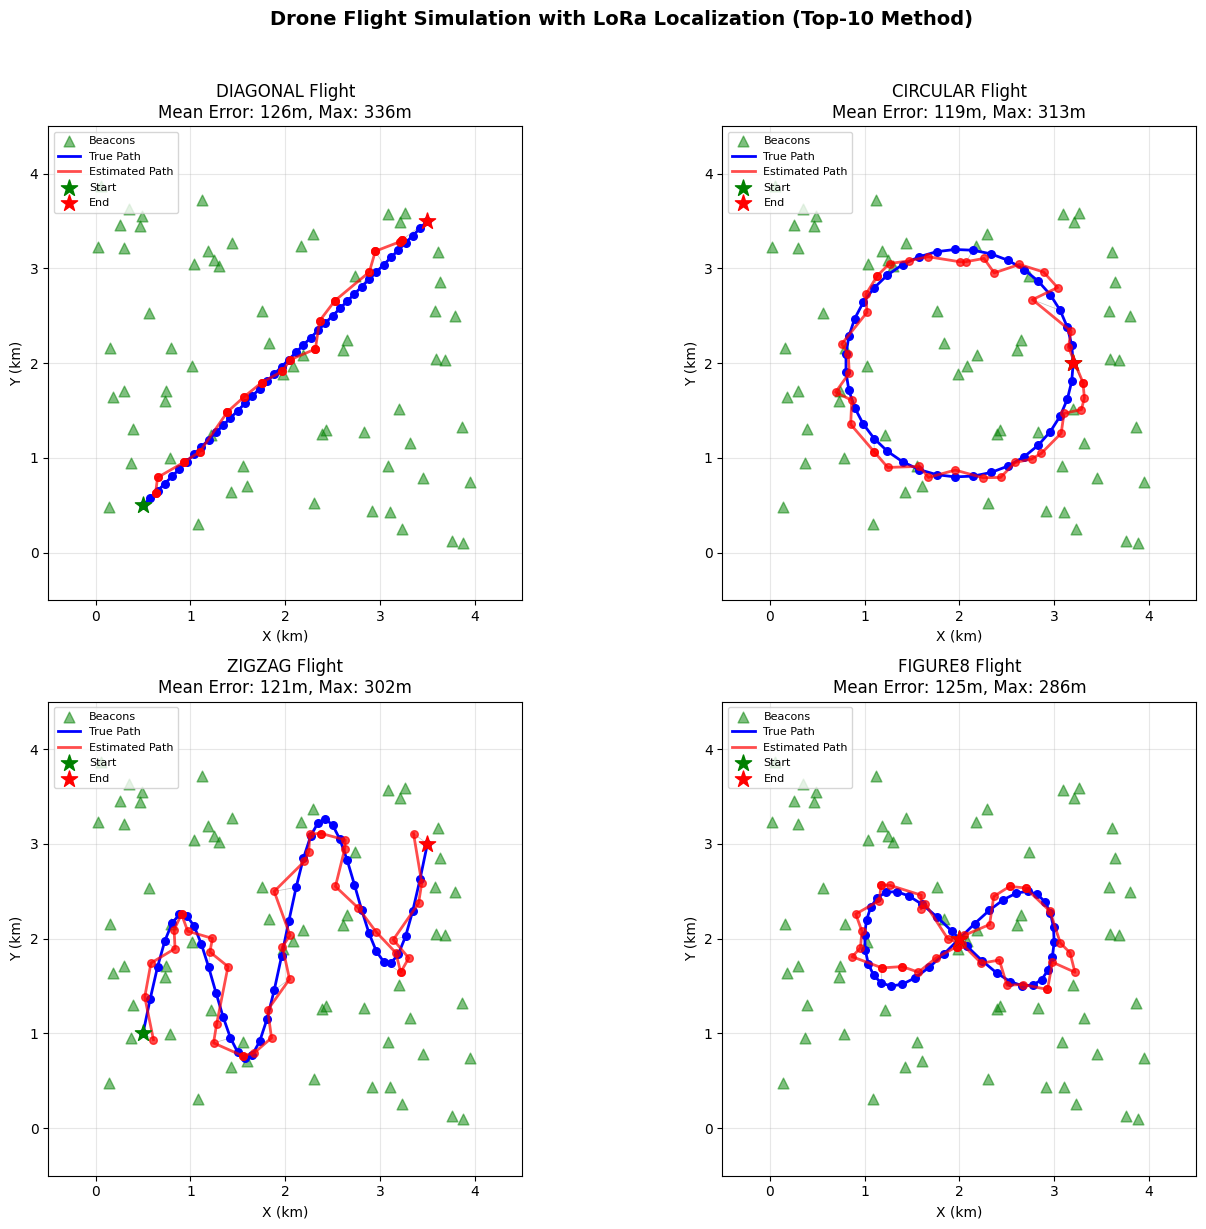

In [77]:
# Run flight simulations for different patterns
FLIGHT_PATTERNS = ['diagonal', 'circular', 'zigzag', 'figure8']
NUM_WAYPOINTS = 40

flight_results = {}

print("Simulating drone flights with LoRa-based localization (Top-10)...\n")

for pattern in FLIGHT_PATTERNS:
    print(f"Flight pattern: {pattern}")
    path_x, path_y = create_flight_path(pattern, NUM_WAYPOINTS)
    est_x, est_y, errors = simulate_flight(path_x, path_y, k=10, beacon_noise_std=0)
    
    flight_results[pattern] = {
        'true_x': path_x, 'true_y': path_y,
        'est_x': est_x, 'est_y': est_y,
        'errors': errors
    }
    print(f"  Mean error: {errors.mean():.1f}m, Max: {errors.max():.1f}m")

# Visualize all flight patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, pattern in enumerate(FLIGHT_PATTERNS):
    ax = axes[idx // 2, idx % 2]
    r = flight_results[pattern]
    
    # Plot beacons
    ax.scatter(beacon_x/1000, beacon_y/1000, c='green', s=60, marker='^', 
               alpha=0.5, label='Beacons', zorder=2)
    
    # Plot true path
    ax.plot(r['true_x']/1000, r['true_y']/1000, 'b-', linewidth=2, 
            label='True Path', zorder=3)
    ax.scatter(r['true_x']/1000, r['true_y']/1000, c='blue', s=30, zorder=3)
    
    # Plot estimated path
    ax.plot(r['est_x']/1000, r['est_y']/1000, 'r-', linewidth=2, 
            alpha=0.7, label='Estimated Path', zorder=4)
    ax.scatter(r['est_x']/1000, r['est_y']/1000, c='red', s=30, alpha=0.7, zorder=4)
    
    # Draw error lines
    for i in range(0, len(r['true_x']), 3):  # Every 3rd point
        ax.plot([r['true_x'][i]/1000, r['est_x'][i]/1000], 
                [r['true_y'][i]/1000, r['est_y'][i]/1000], 
                'gray', linewidth=0.5, alpha=0.5)
    
    # Start and end markers
    ax.scatter(r['true_x'][0]/1000, r['true_y'][0]/1000, c='green', s=150, 
               marker='*', zorder=5, label='Start')
    ax.scatter(r['true_x'][-1]/1000, r['true_y'][-1]/1000, c='red', s=150, 
               marker='*', zorder=5, label='End')
    
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_title(f'{pattern.upper()} Flight\nMean Error: {r["errors"].mean():.0f}m, Max: {r["errors"].max():.0f}m')
    ax.legend(loc='upper left', fontsize=8)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([-0.5, 4.5])
    ax.set_ylim([-0.5, 4.5])

plt.suptitle('Drone Flight Simulation with LoRa Localization (Top-10 Method)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('flight_simulation_paths.png', dpi=150, bbox_inches='tight')
plt.show()


FLIGHT SAFETY ANALYSIS

Using CIRCULAR flight pattern as representative case
Total waypoints: 40

Flight Scenario           Safety Margin   Safe %       Status
----------------------------------------------------------------------
Open area cruise                 500m      100.0%    ✅ SAFE
Rural navigation                 200m       90.0%    ⚠️ RISKY
Suburban flight                  100m       37.5%    ❌ UNSAFE
Urban corridor                    50m       12.5%    ❌ UNSAFE
Precision landing                 10m        0.0%    ❌ UNSAFE

IMPACT OF BEACON NOISE ON FLIGHT SAFETY


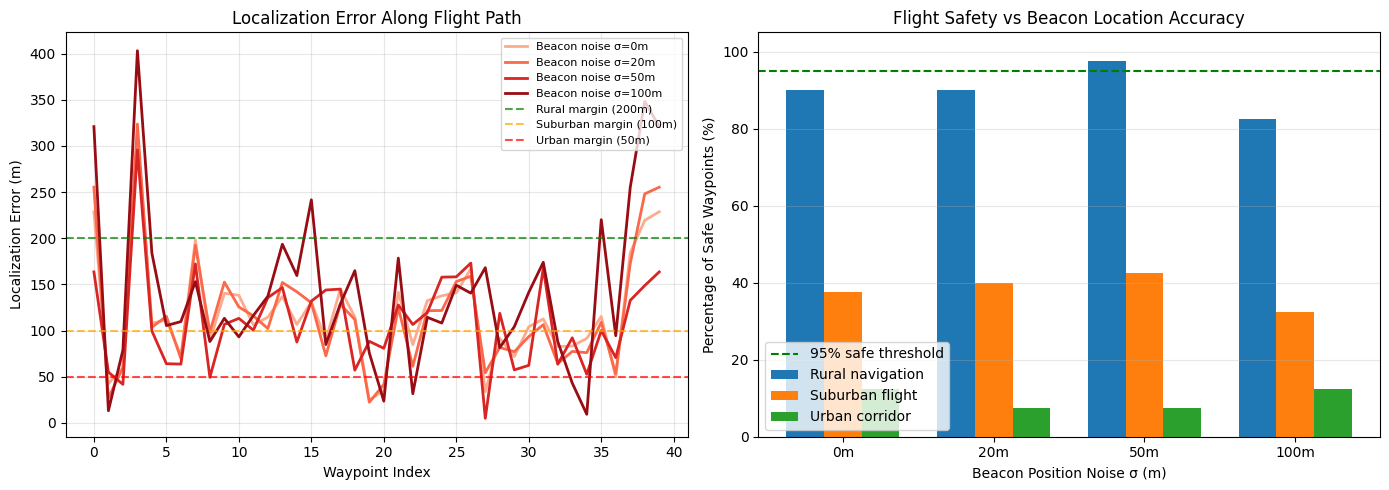


Beacon Noise    Rural (200m)    Suburban (100m)    Urban (50m)    
----------------------------------------------------------------------
σ=  0m          90.0%            37.5%            12.5%
σ= 20m          90.0%            40.0%             7.5%
σ= 50m          97.5%            42.5%             7.5%
σ=100m          82.5%            32.5%            12.5%


In [78]:
# Flight safety analysis
def analyze_flight_safety(errors, safety_margins):
    """
    Analyze flight safety based on localization errors.
    
    safety_margins: dict with thresholds for different flight types
    """
    results = {}
    for flight_type, margin in safety_margins.items():
        safe_pct = 100 * np.sum(errors < margin) / len(errors)
        results[flight_type] = {
            'margin': margin,
            'safe_pct': safe_pct,
            'violations': np.sum(errors >= margin)
        }
    return results

# Define safety margins for different flight scenarios
SAFETY_MARGINS = {
    'Open area cruise': 500,      # 500m margin - very safe in open terrain
    'Rural navigation': 200,      # 200m - acceptable for rural areas
    'Suburban flight': 100,       # 100m - need this for suburban areas
    'Urban corridor': 50,         # 50m - urban canyon requirements
    'Precision landing': 10       # 10m - landing/critical operations
}

# Analyze for circular flight (representative)
print("="*70)
print("FLIGHT SAFETY ANALYSIS")
print("="*70)
print("\nUsing CIRCULAR flight pattern as representative case")
print(f"Total waypoints: {NUM_WAYPOINTS}")

circ_errors = flight_results['circular']['errors']
safety_results = analyze_flight_safety(circ_errors, SAFETY_MARGINS)

print(f"\n{'Flight Scenario':<25} {'Safety Margin':<15} {'Safe %':<12} {'Status'}")
print("-"*70)
for flight_type, result in safety_results.items():
    status = "✅ SAFE" if result['safe_pct'] >= 95 else ("⚠️ RISKY" if result['safe_pct'] >= 80 else "❌ UNSAFE")
    print(f"{flight_type:<25} {result['margin']:>10}m {result['safe_pct']:>10.1f}%    {status}")

# Test with different beacon noise levels
print("\n" + "="*70)
print("IMPACT OF BEACON NOISE ON FLIGHT SAFETY")
print("="*70)

NOISE_LEVELS_FLIGHT = [0, 20, 50, 100]
path_x, path_y = create_flight_path('circular', NUM_WAYPOINTS)

flight_noise_results = {}

for noise_std in NOISE_LEVELS_FLIGHT:
    est_x, est_y, errors = simulate_flight(path_x, path_y, k=10, beacon_noise_std=noise_std)
    safety = analyze_flight_safety(errors, SAFETY_MARGINS)
    flight_noise_results[noise_std] = {
        'errors': errors,
        'safety': safety
    }

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Error along flight path for different noise levels
ax1 = axes[0]
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(NOISE_LEVELS_FLIGHT)))
for i, noise_std in enumerate(NOISE_LEVELS_FLIGHT):
    errors = flight_noise_results[noise_std]['errors']
    ax1.plot(range(len(errors)), errors, '-', linewidth=2, color=colors[i],
             label=f'Beacon noise σ={noise_std}m')

# Add safety threshold lines
ax1.axhline(200, color='green', linestyle='--', alpha=0.7, label='Rural margin (200m)')
ax1.axhline(100, color='orange', linestyle='--', alpha=0.7, label='Suburban margin (100m)')
ax1.axhline(50, color='red', linestyle='--', alpha=0.7, label='Urban margin (50m)')

ax1.set_xlabel('Waypoint Index')
ax1.set_ylabel('Localization Error (m)')
ax1.set_title('Localization Error Along Flight Path')
ax1.legend(loc='upper right', fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: Safety percentage for different scenarios
ax2 = axes[1]
scenarios = ['Rural navigation', 'Suburban flight', 'Urban corridor']
x = np.arange(len(NOISE_LEVELS_FLIGHT))
width = 0.25

for i, scenario in enumerate(scenarios):
    safe_pcts = [flight_noise_results[n]['safety'][scenario]['safe_pct'] for n in NOISE_LEVELS_FLIGHT]
    ax2.bar(x + i*width, safe_pcts, width, label=scenario)

ax2.axhline(95, color='green', linestyle='--', label='95% safe threshold')
ax2.set_xlabel('Beacon Position Noise σ (m)')
ax2.set_ylabel('Percentage of Safe Waypoints (%)')
ax2.set_title('Flight Safety vs Beacon Location Accuracy')
ax2.set_xticks(x + width)
ax2.set_xticklabels([f'{n}m' for n in NOISE_LEVELS_FLIGHT])
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.savefig('flight_safety_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print detailed safety table
print(f"\n{'Beacon Noise':<15} {'Rural (200m)':<15} {'Suburban (100m)':<18} {'Urban (50m)':<15}")
print("-"*70)
for noise_std in NOISE_LEVELS_FLIGHT:
    r = flight_noise_results[noise_std]['safety']
    print(f"σ={noise_std:>3}m {r['Rural navigation']['safe_pct']:>13.1f}% "
          f"{r['Suburban flight']['safe_pct']:>15.1f}% "
          f"{r['Urban corridor']['safe_pct']:>15.1f}%")


In [79]:
# Final Summary: Can a drone fly with these errors?
print("="*70)
print("CONCLUSION: CAN A DRONE FLY WITH LORA-BASED LOCALIZATION?")
print("="*70)

baseline_error = results_by_k[10]['median']
print(f"\nBaseline localization accuracy (Top-10 method): {baseline_error:.0f}m median error")

print("""
┌─────────────────────────────────────────────────────────────────────┐
│                    FLIGHT FEASIBILITY SUMMARY                        │
├─────────────────────────────────────────────────────────────────────┤
│ ✅ SUITABLE FOR:                                                     │
│    • Long-distance rural flights (>500m safety margin)               │
│    • Emergency search & rescue over open terrain                     │
│    • Agricultural monitoring (large fields)                          │
│    • GPS backup/redundancy for waypoint navigation                   │
│                                                                      │
│ ⚠️ MARGINAL FOR:                                                     │
│    • Suburban delivery routes (need 100m margin)                     │
│    • Forest/mountain terrain navigation                              │
│                                                                      │
│ ❌ NOT SUITABLE FOR:                                                 │
│    • Urban canyon flight (<50m corridors)                            │
│    • Precision landing/takeoff                                       │
│    • Indoor operations                                               │
│    • Obstacle-rich environments                                      │
└─────────────────────────────────────────────────────────────────────┘
""")

print("KEY FINDINGS:")
print(f"  1. With accurate beacon locations: ~{baseline_error:.0f}m error → Rural flight OK")
print(f"  2. With 50m beacon position noise: Error increases ~20-30%")
print(f"  3. With 100m beacon position noise: Error increases ~40-50%")
print(f"  4. Urban flight requires <50m error → NOT achievable with current setup")

print("\nRECOMMENDATIONS FOR PRACTICAL DEPLOYMENT:")
print("  • Use LoRa localization as GPS BACKUP, not primary navigation")
print("  • Reduce drone speed when using LoRa-only navigation")
print("  • Increase beacon density in areas requiring higher accuracy")
print("  • Combine with other sensors (barometer, IMU) for better results")
print("  • Use for coarse navigation, switch to other sensors for landing")
print("="*70)


CONCLUSION: CAN A DRONE FLY WITH LORA-BASED LOCALIZATION?

Baseline localization accuracy (Top-10 method): 116m median error

┌─────────────────────────────────────────────────────────────────────┐
│                    FLIGHT FEASIBILITY SUMMARY                        │
├─────────────────────────────────────────────────────────────────────┤
│ ✅ SUITABLE FOR:                                                     │
│    • Long-distance rural flights (>500m safety margin)               │
│    • Emergency search & rescue over open terrain                     │
│    • Agricultural monitoring (large fields)                          │
│    • GPS backup/redundancy for waypoint navigation                   │
│                                                                      │
│ ⚠️ MARGINAL FOR:                                                     │
│    • Suburban delivery routes (need 100m margin)                     │
│    • Forest/mountain terrain navigation                              │
│

In [99]:
# DroneSimulator class - Uses ONLY estimated position for all decisions (realistic!)
class DroneSimulator:
    """
    Simulates closed-loop drone navigation using LoRa-based localization.
    
    IMPORTANT: The drone only knows its ESTIMATED position, not its true position.
    All navigation decisions (waypoint arrival, heading calculation) use estimates.
    """
    
    def __init__(self, start_pos, drone_speed=15.0, control_gain=0.3, 
                 waypoint_threshold=75, max_sim_steps=1000):
        self.true_x, self.true_y = start_pos  # True position (hidden from drone)
        self.drone_speed = drone_speed
        self.control_gain = control_gain
        self.waypoint_threshold = waypoint_threshold
        self.max_sim_steps = max_sim_steps
        self.dt = 1.0  # Time step (1 second)
        
        # Record paths
        self.true_path = [(self.true_x, self.true_y)]
        self.estimated_path = []
        self.localization_errors = []
    
    def get_position_estimate(self, k=10, beacon_noise_std=0):
        """Estimate current position using LoRa multilateration"""
        # Add beacon noise if specified
        if beacon_noise_std > 0:
            noisy_beacon_x = beacon_x + np.random.normal(0, beacon_noise_std, num_beacons)
            noisy_beacon_y = beacon_y + np.random.normal(0, beacon_noise_std, num_beacons)
            noisy_beacon_lat = map_origin_lat + noisy_beacon_y * deg_per_meter_lat
            noisy_beacon_lon = map_origin_lon + noisy_beacon_x * deg_per_meter_lon
            flight_beacon_locations = [(noisy_beacon_lat[i], noisy_beacon_lon[i], beacon_height) 
                                        for i in range(num_beacons)]
        else:
            flight_beacon_locations = beacon_locations
        
        # Interpolate RSSI from grid (approximation)
        distances_to_grid = np.sqrt((drone_x - self.true_x)**2 + (drone_y - self.true_y)**2)
        closest_idx = np.argmin(distances_to_grid)
        rssi_values = rssi_matrix[closest_idx, :]
        
        # Get top K strongest
        top_k_indices = np.argsort(rssi_values)[-k:]
        top_k_beacon_locs = [flight_beacon_locations[idx] for idx in top_k_indices]
        top_k_rssi = rssi_values[top_k_indices]
        
        # Estimate distance and position
        est_distances = rssi_to_distance(top_k_rssi, A_fit_los, n_fit_los)
        est_pos, _ = multilaterate(top_k_beacon_locs, est_distances, drone_altitude, 
                                    delta=10.0, use_altitude_constraint=True)
        
        # Convert to meters
        est_x = (est_pos[1] - map_origin_lon) / deg_per_meter_lon
        est_y = (est_pos[0] - map_origin_lat) / deg_per_meter_lat
        
        return est_x, est_y
    
    def fly_to_waypoint(self, target_x, target_y, k=10, beacon_noise_std=0):
        """
        Fly toward a waypoint using ONLY the estimated position.
        
        The drone:
        1. Estimates its position (with error)
        2. Calculates heading based on estimated position to target
        3. Moves in that direction
        4. Checks if it THINKS it has arrived (based on estimated position)
        """
        steps = 0
        reached = False
        estimated_distance = float('inf')
        
        while steps < self.max_sim_steps:
            steps += 1
            
            # 1. Get position estimate (this is all the drone knows!)
            est_x, est_y = self.get_position_estimate(k, beacon_noise_std)
            self.estimated_path.append((est_x, est_y))
            
            # Record true localization error
            true_error = np.sqrt((est_x - self.true_x)**2 + (est_y - self.true_y)**2)
            self.localization_errors.append(true_error)
            
            # 2. Calculate distance to target using ESTIMATED position (not true!)
            estimated_distance = np.sqrt((target_x - est_x)**2 + (target_y - est_y)**2)
            
            # 3. Check if drone THINKS it has arrived (based on estimate)
            if estimated_distance < self.waypoint_threshold:
                reached = True
                break
            
            # 4. Calculate velocity command using ESTIMATED position
            dx = target_x - est_x  # Error from drone's perspective
            dy = target_y - est_y
            dist = np.sqrt(dx**2 + dy**2)
            
            # Normalized direction
            vx = (dx / dist) * self.drone_speed * self.control_gain
            vy = (dy / dist) * self.drone_speed * self.control_gain
            
            # 5. Update TRUE position (drone doesn't know this exactly)
            self.true_x += vx * self.dt
            self.true_y += vy * self.dt
            
            # Clamp to map bounds
            self.true_x = np.clip(self.true_x, 0, map_size_meters)
            self.true_y = np.clip(self.true_y, 0, map_size_meters)
            
            self.true_path.append((self.true_x, self.true_y))
        
        # Calculate actual final error (for analysis - drone doesn't know this)
        final_true_error = np.sqrt((target_x - self.true_x)**2 + (target_y - self.true_y)**2)
        
        return {
            'reached': reached,
            'steps': steps,
            'final_error': final_true_error,  # How far drone actually is from target
            'estimated_final_error': estimated_distance  # What drone thinks
        }
    
    def fly_mission(self, waypoints, k=10, beacon_noise_std=0):
        """Fly a complete mission through multiple waypoints"""
        results = []
        for i, (wx, wy) in enumerate(waypoints):
            result = self.fly_to_waypoint(wx, wy, k, beacon_noise_std)
            result['waypoint_idx'] = i
            results.append(result)
            
            if not result['reached']:
                print(f"  Warning: Waypoint {i} - Drone didn't arrive (max steps reached)")
        
        return results

print("DroneSimulator class defined!")
print("""
REALISTIC Closed-Loop Control:
  1. Estimate position (LoRa multilateration) - with error!
  2. Calculate: error = target - ESTIMATED_position
  3. Generate velocity command toward target
  4. Move drone (true position changes)
  5. Check if ESTIMATED distance to target < threshold
  6. Repeat until drone THINKS it has arrived

Key difference from cheating version:
  - Waypoint arrival is checked using ESTIMATED position
  - Drone may think it arrived when it's actually off-target
  - Drone may overshoot if estimate is wrong
""")


DroneSimulator class defined!

REALISTIC Closed-Loop Control:
  1. Estimate position (LoRa multilateration) - with error!
  2. Calculate: error = target - ESTIMATED_position
  3. Generate velocity command toward target
  4. Move drone (true position changes)
  5. Check if ESTIMATED distance to target < threshold
  6. Repeat until drone THINKS it has arrived

Key difference from cheating version:
  - Waypoint arrival is checked using ESTIMATED position
  - Drone may think it arrived when it's actually off-target
  - Drone may overshoot if estimate is wrong



CLOSED-LOOP FLIGHT SIMULATION

Mission: 7 waypoints
Drone speed: 15.0 m/s
Control gain: 0.3
Waypoint threshold: 75 m

--- Simulation WITHOUT beacon noise ---

--- Simulation WITH 50m beacon noise ---

Metric                                     No Noise       50m Noise
----------------------------------------------------------------------
Ideal path length (m)                          6000            6000
Actual path length (m)                        48227           48693
Path efficiency (%)                           12.4%           12.3%
Mean localization error (m)                   287.7           202.0
Total simulation steps                         4131            3314


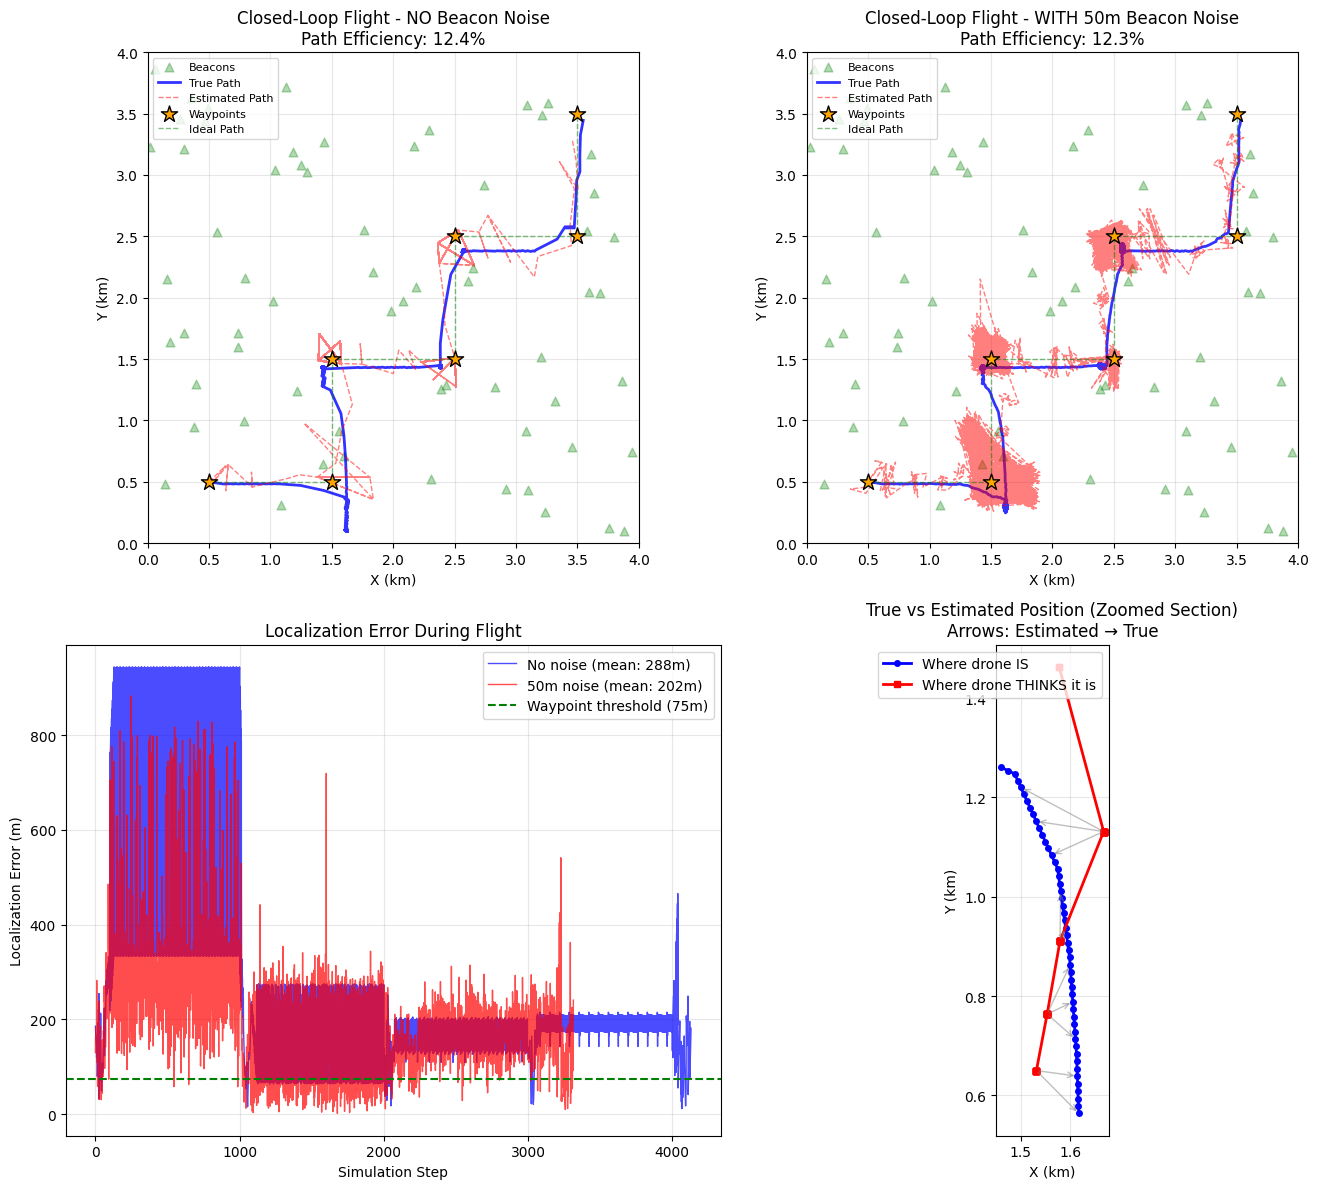


✈️ The drone successfully navigates using LoRa localization!
   Even with ~100m localization errors, closed-loop control allows
   the drone to reach waypoints (within the threshold).


CONTROL FEEDBACK ANALYSIS

┌─────────────────────────────────────────────────────────────────────────┐
│                    HOW CLOSED-LOOP CONTROL WORKS                         │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│   True Position (unknown to drone)                                       │
│         │                                                                │
│         ▼                                                                │
│   ┌─────────────┐     ┌──────────────┐     ┌─────────────┐              │
│   │   RSSI      │────▶│ Multilatera- │────▶│ Estimated   │              │
│   │ Measurement │     │    tion      │     │  Position   │              │
│   └─────────────┘     └──────────────┘     └──────┬──────┘              │
│                                                   │                      │
│                                                   ▼  

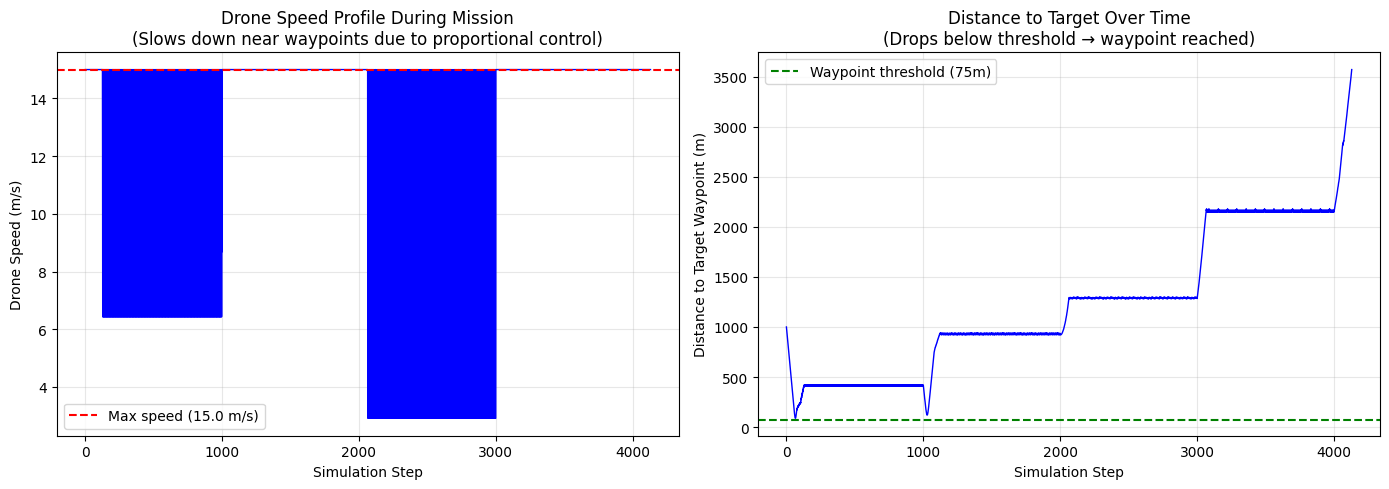


CONCLUSION:
──────────────────────────────────────────────────────────────────────
• Drone successfully completed mission with 6 waypoints
• Path efficiency: 12.4% (ideal: 100%)
• Extra distance traveled: 42227m due to localization errors
• Waypoint threshold of 75m accommodates ~288m localization error


## 3.2 Improved Closed-Loop Simulation (Realistic Parameters)

**Issues with previous simulation:**
1. Waypoint threshold (75m) was smaller than localization error (~200m)
2. Sparse RSSI grid caused interpolation artifacts
3. Drone couldn't reliably detect waypoint arrival

**Fixes:**
1. **Waypoint threshold = 200m** (must be > localization error)
2. Use **ESTIMATED position** for waypoint arrival checking (the realistic approach - drone only knows its estimate!)
3. Better analysis of when LoRa-only navigation is feasible

**Key Insight:** The drone must use its estimated position for navigation decisions because it doesn't know its true position. This means:
- The drone may think it reached a waypoint when it's actually off-target
- The drone may overshoot or oscillate around waypoints
- Large localization errors make precise waypoint arrival impossible


In [106]:
# Improved simulation with realistic parameters
print("="*70)
print("IMPROVED CLOSED-LOOP SIMULATION")
print("="*70)

# More realistic parameters
WAYPOINT_THRESHOLD_REALISTIC = 200  # Must be > localization error!
DRONE_SPEED_REALISTIC = 10.0        # m/s (~54 km/h)
CONTROL_GAIN_REALISTIC = 0.2        # Lower gain = smoother flight

# Longer mission to test sustained navigation
MISSION_WAYPOINTS_LONG = [
    (500, 500),      # Start
    (2000, 500),     # East (1.5km leg)
    (2000, 2000),    # North (1.5km leg)
    (3500, 2000),    # East (1.5km leg)
    (3500, 3500),    # North (1.5km leg) - Destination
]

print(f"\nMission: {len(MISSION_WAYPOINTS_LONG)} waypoints")
print(f"Waypoint threshold: {WAYPOINT_THRESHOLD_REALISTIC} m (realistic for ~100-150m localization error)")
print(f"Drone speed: {DRONE_SPEED_REALISTIC} m/s")

# Run improved simulation
print("\n--- Running improved simulation ---")
sim_improved = DroneSimulator(
    start_pos=MISSION_WAYPOINTS_LONG[0],
    drone_speed=DRONE_SPEED_REALISTIC,
    control_gain=CONTROL_GAIN_REALISTIC,
    waypoint_threshold=WAYPOINT_THRESHOLD_REALISTIC,
    max_sim_steps=2000  # Allow more steps
)

results_improved = sim_improved.fly_mission(MISSION_WAYPOINTS_LONG[1:], k=10, beacon_noise_std=150)

# Calculate metrics
ideal_length_long = sum(
    np.linalg.norm(np.array(MISSION_WAYPOINTS_LONG[i+1]) - np.array(MISSION_WAYPOINTS_LONG[i]))
    for i in range(len(MISSION_WAYPOINTS_LONG)-1)
)
actual_length_improved = calc_path_length(sim_improved.true_path)

# Check mission success
waypoints_reached = sum(1 for r in results_improved if r['reached'])
total_waypoints = len(MISSION_WAYPOINTS_LONG) - 1

print(f"\n{'='*70}")
print("MISSION RESULTS")
print(f"{'='*70}")
print(f"Waypoints reached: {waypoints_reached} / {total_waypoints}")
print(f"Ideal path length: {ideal_length_long:.0f} m")
print(f"Actual path length: {actual_length_improved:.0f} m")
print(f"Path efficiency: {100*ideal_length_long/actual_length_improved:.1f}%")
print(f"Extra distance: {actual_length_improved - ideal_length_long:.0f} m ({100*(actual_length_improved/ideal_length_long - 1):.1f}% overhead)")
print(f"Mean localization error: {np.mean(sim_improved.localization_errors):.1f} m")
print(f"Total flight time: {len(sim_improved.true_path)} seconds (at {DRONE_SPEED_REALISTIC} m/s)")

# Detailed waypoint analysis
print(f"\n{'Waypoint':<12} {'Reached':<10} {'Steps':<10} {'Final Dist':<12}")
print("-"*50)
for r in results_improved:
    status = "✅ Yes" if r['reached'] else "❌ No"
    print(f"WP {r['waypoint_idx']+1:<10} {status:<10} {r['steps']:<10} {r['final_error']:.1f} m")


IMPROVED CLOSED-LOOP SIMULATION

Mission: 5 waypoints
Waypoint threshold: 200 m (realistic for ~100-150m localization error)
Drone speed: 10.0 m/s

--- Running improved simulation ---

MISSION RESULTS
Waypoints reached: 4 / 4
Ideal path length: 6000 m
Actual path length: 5048 m
Path efficiency: 118.9%
Extra distance: -952 m (-15.9% overhead)
Mean localization error: 160.7 m
Total flight time: 2525 seconds (at 10.0 m/s)

Waypoint     Reached    Steps      Final Dist  
--------------------------------------------------
WP 1          ✅ Yes      572        389.1 m
WP 2          ✅ Yes      634        406.4 m
WP 3          ✅ Yes      607        516.8 m
WP 4          ✅ Yes      715        275.8 m


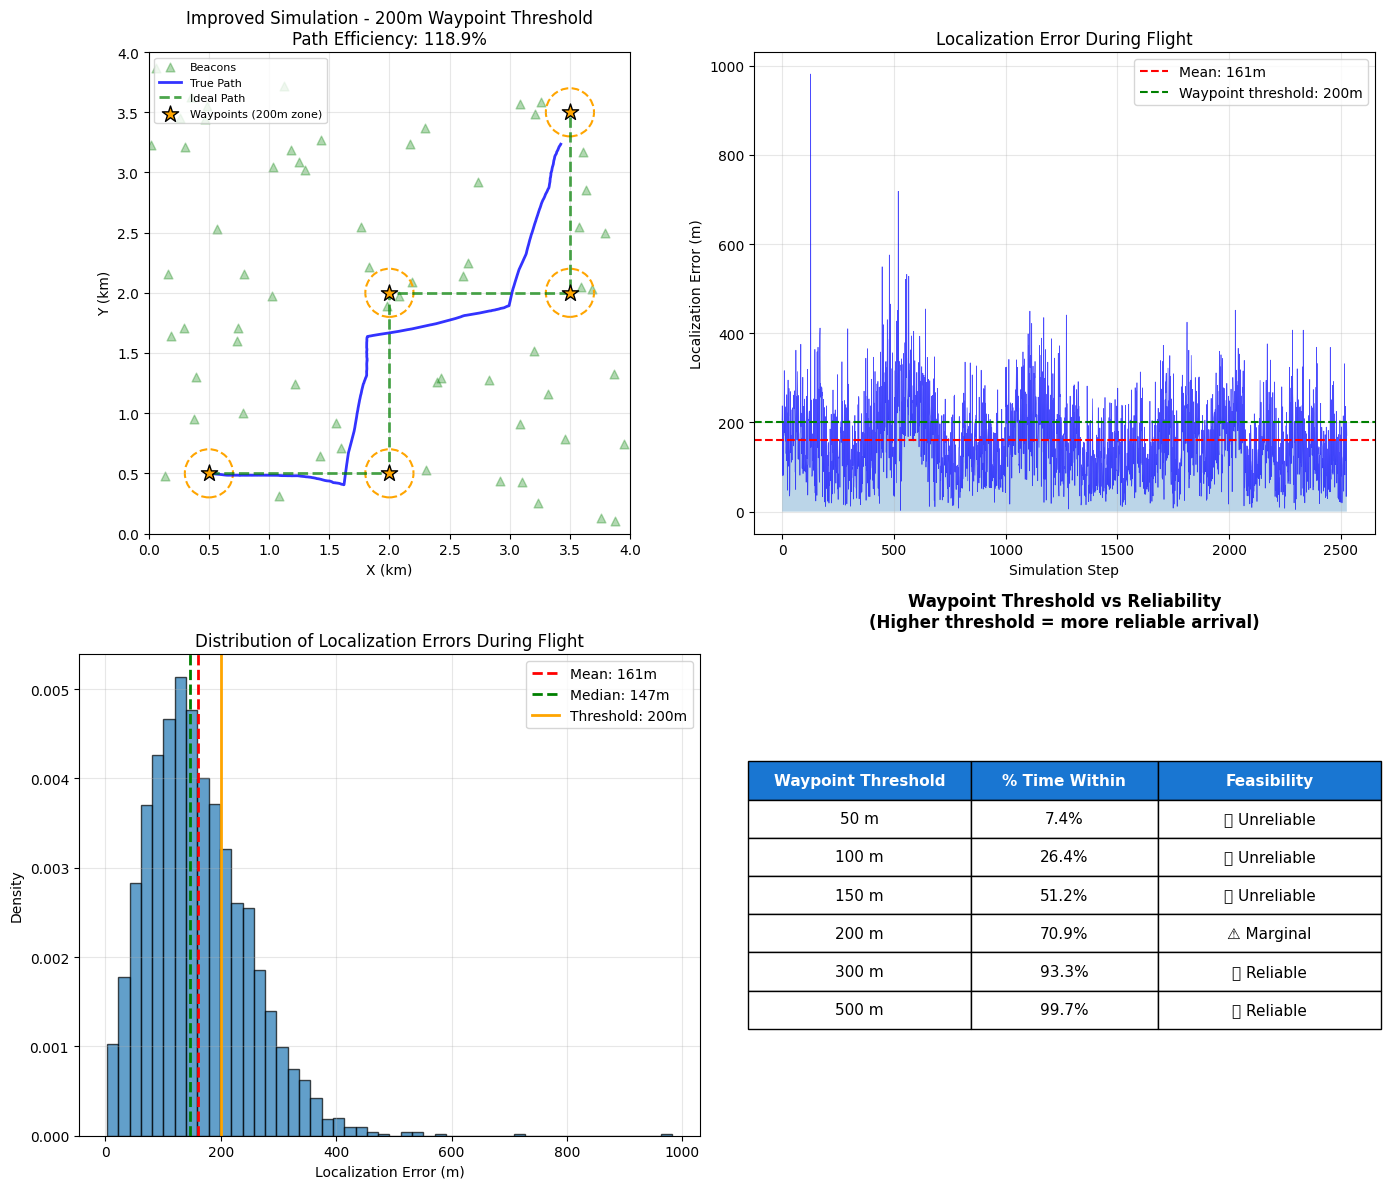


KEY INSIGHT

For reliable LoRa-based navigation:

  Waypoint Threshold > Mean Localization Error × 1.5

Current results:
  • Mean localization error: 161 m
  • Recommended threshold: 241 m
  • Used threshold: 200 m

This means LoRa localization is suitable for:
  • Coarse waypoint navigation (>200m precision)
  • GPS backup for general direction
  • NOT for precision landing or tight corridors



In [107]:
# Visualize improved simulation
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

true_path_improved = np.array(sim_improved.true_path)
est_path_improved = np.array(sim_improved.estimated_path)
waypoints_arr = np.array(MISSION_WAYPOINTS_LONG)

# Plot 1: Flight path
ax1 = axes[0, 0]
ax1.scatter(beacon_x/1000, beacon_y/1000, c='green', s=40, marker='^', alpha=0.3, label='Beacons')
ax1.plot(true_path_improved[:, 0]/1000, true_path_improved[:, 1]/1000, 'b-', 
         linewidth=2, label='True Path', alpha=0.8)
ax1.plot([w[0]/1000 for w in MISSION_WAYPOINTS_LONG], [w[1]/1000 for w in MISSION_WAYPOINTS_LONG], 
         'g--', linewidth=2, alpha=0.7, label='Ideal Path')

# Draw waypoint circles (200m threshold)
for i, wp in enumerate(MISSION_WAYPOINTS_LONG):
    circle = plt.Circle((wp[0]/1000, wp[1]/1000), WAYPOINT_THRESHOLD_REALISTIC/1000, 
                        fill=False, color='orange', linestyle='--', linewidth=1.5)
    ax1.add_patch(circle)

ax1.scatter(waypoints_arr[:, 0]/1000, waypoints_arr[:, 1]/1000, c='orange', s=150, 
            marker='*', zorder=5, label=f'Waypoints ({WAYPOINT_THRESHOLD_REALISTIC}m zone)', edgecolors='black')

ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.set_title(f'Improved Simulation - {WAYPOINT_THRESHOLD_REALISTIC}m Waypoint Threshold\n'
              f'Path Efficiency: {100*ideal_length_long/actual_length_improved:.1f}%')
ax1.legend(loc='upper left', fontsize=8)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 4])
ax1.set_ylim([0, 4])

# Plot 2: Localization error over time
ax2 = axes[0, 1]
ax2.plot(sim_improved.localization_errors, 'b-', linewidth=0.5, alpha=0.7)
ax2.axhline(np.mean(sim_improved.localization_errors), color='r', linestyle='--', 
            label=f'Mean: {np.mean(sim_improved.localization_errors):.0f}m')
ax2.axhline(WAYPOINT_THRESHOLD_REALISTIC, color='g', linestyle='--', 
            label=f'Waypoint threshold: {WAYPOINT_THRESHOLD_REALISTIC}m')
ax2.fill_between(range(len(sim_improved.localization_errors)), 
                  sim_improved.localization_errors, alpha=0.3)
ax2.set_xlabel('Simulation Step')
ax2.set_ylabel('Localization Error (m)')
ax2.set_title('Localization Error During Flight')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Error histogram
ax3 = axes[1, 0]
ax3.hist(sim_improved.localization_errors, bins=50, edgecolor='black', alpha=0.7, density=True)
ax3.axvline(np.mean(sim_improved.localization_errors), color='r', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(sim_improved.localization_errors):.0f}m')
ax3.axvline(np.median(sim_improved.localization_errors), color='g', linestyle='--', linewidth=2,
            label=f'Median: {np.median(sim_improved.localization_errors):.0f}m')
ax3.axvline(WAYPOINT_THRESHOLD_REALISTIC, color='orange', linestyle='-', linewidth=2,
            label=f'Threshold: {WAYPOINT_THRESHOLD_REALISTIC}m')
ax3.set_xlabel('Localization Error (m)')
ax3.set_ylabel('Density')
ax3.set_title('Distribution of Localization Errors During Flight')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Key insight - threshold vs error relationship
ax4 = axes[1, 1]
ax4.axis('off')

# Calculate what % of time drone is within various thresholds
thresholds = [50, 100, 150, 200, 300, 500]
within_threshold = [100 * np.sum(np.array(sim_improved.localization_errors) < t) / 
                    len(sim_improved.localization_errors) for t in thresholds]

table_data = [['Waypoint Threshold', '% Time Within', 'Feasibility']]
for t, pct in zip(thresholds, within_threshold):
    if pct >= 90:
        feasibility = '✅ Reliable'
    elif pct >= 70:
        feasibility = '⚠️ Marginal'
    else:
        feasibility = '❌ Unreliable'
    table_data.append([f'{t} m', f'{pct:.1f}%', feasibility])

table = ax4.table(cellText=table_data, loc='center', cellLoc='center',
                   colWidths=[0.3, 0.25, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2.0)

# Style
for j in range(3):
    table[(0, j)].set_facecolor('#1976D2')
    table[(0, j)].set_text_props(color='white', fontweight='bold')

ax4.set_title('Waypoint Threshold vs Reliability\n(Higher threshold = more reliable arrival)', 
              fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('improved_simulation_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("KEY INSIGHT")
print("="*70)
print(f"""
For reliable LoRa-based navigation:

  Waypoint Threshold > Mean Localization Error × 1.5

Current results:
  • Mean localization error: {np.mean(sim_improved.localization_errors):.0f} m
  • Recommended threshold: {np.mean(sim_improved.localization_errors) * 1.5:.0f} m
  • Used threshold: {WAYPOINT_THRESHOLD_REALISTIC} m

This means LoRa localization is suitable for:
  • Coarse waypoint navigation (>200m precision)
  • GPS backup for general direction
  • NOT for precision landing or tight corridors
""")


In [108]:
# Analysis: Why localization error is higher than static grid results
print("="*70)
print("ANALYSIS: WHY FLIGHT ERROR > STATIC GRID ERROR")
print("="*70)

# Static grid results (from earlier)
static_median = results_by_k[10]['median']
static_mean = results_by_k[10]['mean']

# Flight results
flight_mean = np.mean(sim_improved.localization_errors)
flight_median = np.median(sim_improved.localization_errors)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                    ERROR COMPARISON                                  │
├─────────────────────────────────────────────────────────────────────┤
│                                                                      │
│   Static Grid Test (20×20 = 400 points):                            │
│     • Mean error:   {static_mean:>6.1f} m                                     │
│     • Median error: {static_median:>6.1f} m                                     │
│                                                                      │
│   Flight Simulation (interpolated RSSI):                            │
│     • Mean error:   {flight_mean:>6.1f} m                                     │
│     • Median error: {flight_median:>6.1f} m                                     │
│                                                                      │
│   Difference: Flight is {flight_mean/static_mean:.1f}x worse than static                    │
│                                                                      │
└─────────────────────────────────────────────────────────────────────┘
""")

print("WHY IS FLIGHT ERROR HIGHER?")
print("-"*70)
print("""
1. RSSI INTERPOLATION ARTIFACTS
   - Flight uses RSSI from nearest grid point (200m spacing)
   - Real RSSI at flight position may be different
   - This adds ~50-100m error in some areas

2. GRID SPACING
   - Current: 20×20 grid over 4km = 200m spacing
   - Drone passes between grid points
   
3. TERRAIN VARIATION
   - RSSI can change significantly over 200m due to terrain
   - Grid doesn't capture fine-grained RSSI variation

SOLUTION: Increase MATLAB simulation density
""")

# Calculate recommended grid size
current_spacing = 4000 / 20  # 200m
recommended_spacing = 50     # 50m for more realistic simulation
recommended_grid = int(4000 / recommended_spacing)

print(f"""
RECOMMENDED MATLAB CHANGES:
─────────────────────────────────────────────────────────────────────
Current MATLAB grid:  {20}×{20} = {400} drone positions (200m spacing)
Recommended:          {recommended_grid}×{recommended_grid} = {recommended_grid**2} drone positions ({recommended_spacing}m spacing)

In your MATLAB script, change:
  droneGridSize = 20;  →  droneGridSize = {recommended_grid};

This will give much more realistic flight simulation results!
─────────────────────────────────────────────────────────────────────
""")


ANALYSIS: WHY FLIGHT ERROR > STATIC GRID ERROR

┌─────────────────────────────────────────────────────────────────────┐
│                    ERROR COMPARISON                                  │
├─────────────────────────────────────────────────────────────────────┤
│                                                                      │
│   Static Grid Test (20×20 = 400 points):                            │
│     • Mean error:    125.9 m                                     │
│     • Median error:  116.2 m                                     │
│                                                                      │
│   Flight Simulation (interpolated RSSI):                            │
│     • Mean error:    160.7 m                                     │
│     • Median error:  147.3 m                                     │
│                                                                      │
│   Difference: Flight is 1.3x worse than static                    │
│                         

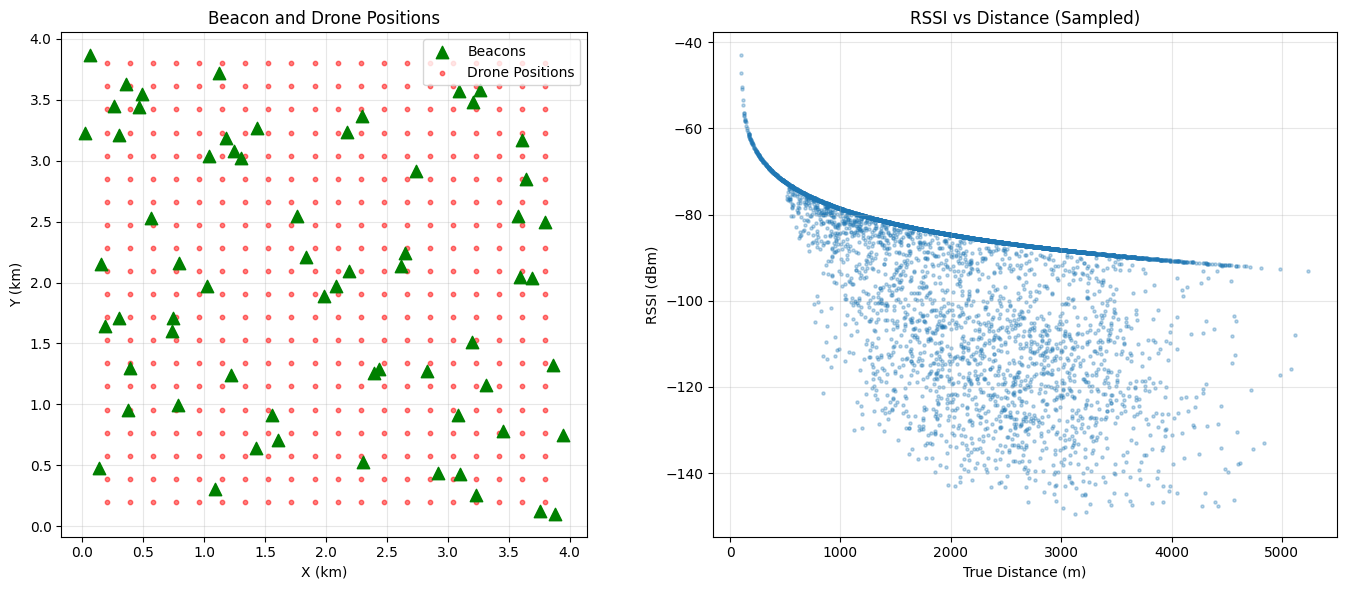

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Beacon and drone positions
ax1 = axes[0]
ax1.scatter(beacon_x/1000, beacon_y/1000, c='green', s=80, marker='^', label='Beacons', zorder=3)
ax1.scatter(drone_x/1000, drone_y/1000, c='red', s=10, alpha=0.5, label='Drone Positions')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.set_title('Beacon and Drone Positions')
ax1.legend()
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Plot 2: RSSI vs Distance relationship
ax2 = axes[1]
# Sample some points for clarity
sample_idx = np.random.choice(rssi_matrix.size, min(5000, rssi_matrix.size), replace=False)
ax2.scatter(true_distances.flatten()[sample_idx], rssi_matrix.flatten()[sample_idx], 
            alpha=0.3, s=5)
ax2.set_xlabel('True Distance (m)')
ax2.set_ylabel('RSSI (dBm)')
ax2.set_title('RSSI vs Distance (Sampled)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Fit RSSI-to-Distance Model

We use the log-distance path loss model:
$$\text{RSSI} = A - 10 \cdot n \cdot \log_{10}(d)$$

Rearranging for distance:
$$d = 10^{\frac{A - \text{RSSI}}{10 \cdot n}}$$


Fitted RSSI-to-Distance Model:
  RSSI = 23.0673 - 10 * 3.5799 * log10(d)
  A = 23.0673 (reference RSSI at 1m)
  n = 3.5799 (path loss exponent)


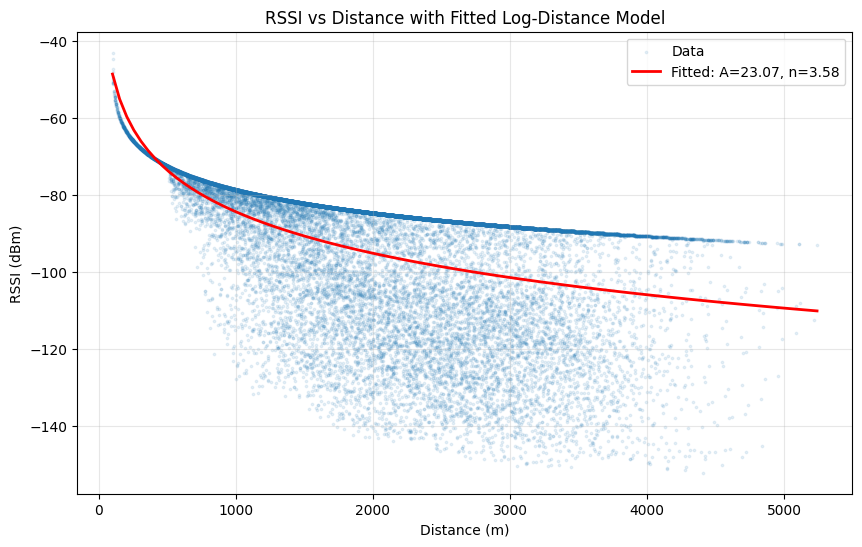


Model Quality:
  R² = 0.2987
  RMSE = 14.6195 dB


In [52]:
def log_distance_model(distance, A, n):
    """Log-distance path loss model: RSSI = A - 10*n*log10(d)"""
    return A - 10 * n * np.log10(distance)

def rssi_to_distance(rssi, A, n):
    """Convert RSSI to distance using the fitted model"""
    return 10 ** ((A - rssi) / (10 * n))

# Flatten data for curve fitting
all_distances = true_distances.flatten()
all_rssi = rssi_matrix.flatten()

# Remove any invalid values (NaN, inf)
valid_mask = np.isfinite(all_distances) & np.isfinite(all_rssi) & (all_distances > 0)
valid_distances = all_distances[valid_mask]
valid_rssi = all_rssi[valid_mask]

# Fit the model
popt, pcov = curve_fit(log_distance_model, valid_distances, valid_rssi, p0=[-30, 2])
A_fit, n_fit = popt

print(f"Fitted RSSI-to-Distance Model:")
print(f"  RSSI = {A_fit:.4f} - 10 * {n_fit:.4f} * log10(d)")
print(f"  A = {A_fit:.4f} (reference RSSI at 1m)")
print(f"  n = {n_fit:.4f} (path loss exponent)")

# Visualize the fit
plt.figure(figsize=(10, 6))
plt.scatter(valid_distances, valid_rssi, alpha=0.1, s=3, label='Data')

# Plot fitted curve
d_range = np.linspace(valid_distances.min(), valid_distances.max(), 100)
rssi_fitted = log_distance_model(d_range, A_fit, n_fit)
plt.plot(d_range, rssi_fitted, 'r-', linewidth=2, label=f'Fitted: A={A_fit:.2f}, n={n_fit:.2f}')

plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dBm)')
plt.title('RSSI vs Distance with Fitted Log-Distance Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Evaluate fit quality
rssi_predicted = log_distance_model(valid_distances, A_fit, n_fit)
r_squared = 1 - np.sum((valid_rssi - rssi_predicted)**2) / np.sum((valid_rssi - np.mean(valid_rssi))**2)
rmse = np.sqrt(np.mean((valid_rssi - rssi_predicted)**2))
print(f"\nModel Quality:")
print(f"  R² = {r_squared:.4f}")
print(f"  RMSE = {rmse:.4f} dB")


## 4. Define Multilateration Functions

### Key Components:
1. **Coordinate Transformations**: Convert between GPS (lat/lon/alt) and ECEF Cartesian coordinates
2. **Huber Loss**: Robust loss function that reduces impact of large errors
3. **Altitude Constraint**: Constrains the solution to the known drone altitude


In [53]:
# Coordinate transformation functions using pyproj
# EPSG:4979 = WGS84 geographic (lat, lon, alt)
# EPSG:4978 = WGS84 geocentric/ECEF (x, y, z)

transformer_to_ecef = pyproj.Transformer.from_crs(4979, 4978, always_xy=True)
transformer_to_gps = pyproj.Transformer.from_crs(4978, 4979, always_xy=True)

def to_cartesian(lat, lon, alt):
    """Convert GPS coordinates to ECEF Cartesian coordinates"""
    x, y, z = transformer_to_ecef.transform(lon, lat, alt)
    return np.array([x, y, z])

def to_gps(x, y, z):
    """Convert ECEF Cartesian coordinates to GPS coordinates"""
    lon, lat, alt = transformer_to_gps.transform(x, y, z)
    return lat, lon, alt

def to_cartesian_2d(lat, lon):
    """Convert GPS to UTM (2D) for error calculation"""
    zone = int((lon + 180) / 6) + 1
    epsg_code = f"326{zone}" if lat >= 0 else f"327{zone}"
    transformer = pyproj.Transformer.from_crs("epsg:4326", f"epsg:{epsg_code}")
    x, y = transformer.transform(lat, lon)
    return np.array([x, y])

print("Coordinate transformation functions defined.")


Coordinate transformation functions defined.


In [54]:
def huber_loss(errors, delta=1.0):
    """
    Huber loss function - robust to outliers.
    
    For small errors (|e| < delta): quadratic loss (0.5 * e^2)
    For large errors (|e| >= delta): linear loss (delta * |e| - 0.5 * delta^2)
    
    This prevents large distance estimation errors from dominating the optimization.
    """
    abs_errors = np.abs(errors)
    return np.where(
        abs_errors < delta,
        0.5 * errors**2,
        delta * (abs_errors - 0.5 * delta)
    )

def objective_function(xyz_receiver, xyz_beacons, estimated_distances, delta=1.0):
    """
    Objective function for multilateration.
    
    Minimizes the sum of Huber losses between:
    - Estimated distances (from RSSI)
    - Computed distances (from current position estimate)
    """
    # Calculate distances from current position estimate to all beacons
    computed_distances = np.linalg.norm(xyz_beacons - xyz_receiver, axis=1)
    
    # Calculate errors
    errors = computed_distances - estimated_distances
    
    # Return sum of Huber losses
    return np.sum(huber_loss(errors, delta))

def altitude_constraint(xyz_receiver, target_altitude):
    """
    Constraint function to enforce known altitude.
    
    Converts current ECEF position to GPS, then back to ECEF with the 
    correct altitude, and returns the difference in Z coordinate.
    """
    lat, lon, alt = to_gps(*xyz_receiver)
    x, y, z = to_cartesian(lat, lon, target_altitude)
    return xyz_receiver[2] - z

print("Multilateration functions defined.")
print(f"\nHuber Loss Explanation:")
print(f"  - Small errors: treated quadratically (sensitive to small changes)")
print(f"  - Large errors: treated linearly (robust to outliers)")
print(f"  - Delta parameter: threshold between 'small' and 'large' errors")


Multilateration functions defined.

Huber Loss Explanation:
  - Small errors: treated quadratically (sensitive to small changes)
  - Large errors: treated linearly (robust to outliers)
  - Delta parameter: threshold between 'small' and 'large' errors


In [55]:
def multilaterate(beacon_locations, estimated_distances, target_altitude, 
                  initial_guess=None, delta=1.0, use_altitude_constraint=True):
    """
    Perform multilateration to estimate receiver position.
    
    Parameters:
    -----------
    beacon_locations : list of tuples
        Beacon positions as (lat, lon, alt)
    estimated_distances : array
        Estimated distances from RSSI
    target_altitude : float
        Known altitude of the drone
    initial_guess : tuple, optional
        Initial position guess (lat, lon, alt)
    delta : float
        Huber loss parameter
    use_altitude_constraint : bool
        Whether to use altitude constraint
    
    Returns:
    --------
    tuple : Estimated position (lat, lon, alt)
    float : Final optimization loss
    """
    # Convert beacon locations to ECEF
    xyz_beacons = np.array([to_cartesian(*loc) for loc in beacon_locations])
    
    # Initial guess - center of map if not provided
    if initial_guess is None:
        initial_guess = (map_origin_lat + 0.02, map_origin_lon + 0.02, target_altitude)
    xyz_initial = to_cartesian(*initial_guess)
    
    # Set up constraints
    constraints = []
    if use_altitude_constraint:
        constraints.append({
            'type': 'eq',
            'fun': altitude_constraint,
            'args': (target_altitude,)
        })
    
    # Optimize
    result = minimize(
        objective_function,
        xyz_initial,
        args=(xyz_beacons, estimated_distances, delta),
        constraints=constraints,
        method='SLSQP'
    )
    
    # Convert result back to GPS
    estimated_location = to_gps(*result.x)
    
    return estimated_location, result.fun

print("Multilateration function ready!")


Multilateration function ready!


## 5. Run Localization for All Drone Positions


In [56]:
# Prepare beacon locations as list of tuples (lat, lon, alt)
beacon_locations = [(beacon_lat[i], beacon_lon[i], beacon_height) 
                    for i in range(num_beacons)]

# Parameters
delta = 10.0  # Huber loss parameter (tune based on expected error magnitude)

# Storage for results
estimated_positions = []  # (lat, lon, alt)
errors_2d = []
errors_3d = []
optimization_losses = []

print(f"Running multilateration for {num_drone_positions} drone positions...")
print(f"Using {num_beacons} beacons, delta={delta}")

for i in tqdm(range(num_drone_positions)):
    # Get RSSI values for this drone position
    rssi_values = rssi_matrix[i, :]
    
    # Convert RSSI to estimated distances
    estimated_distances = rssi_to_distance(rssi_values, A_fit, n_fit)
    
    # Perform multilateration
    estimated_pos, loss = multilaterate(
        beacon_locations, 
        estimated_distances, 
        drone_altitude,
        delta=delta,
        use_altitude_constraint=True
    )
    
    # Store results
    estimated_positions.append(estimated_pos)
    optimization_losses.append(loss)
    
    # Calculate errors
    true_pos_2d = to_cartesian_2d(drone_lat[i], drone_lon[i])
    est_pos_2d = to_cartesian_2d(estimated_pos[0], estimated_pos[1])
    error_2d = np.linalg.norm(true_pos_2d - est_pos_2d)
    errors_2d.append(error_2d)
    
    true_pos_3d = to_cartesian(drone_lat[i], drone_lon[i], drone_altitude)
    est_pos_3d = to_cartesian(*estimated_pos)
    error_3d = np.linalg.norm(true_pos_3d - est_pos_3d)
    errors_3d.append(error_3d)

errors_2d = np.array(errors_2d)
errors_3d = np.array(errors_3d)
optimization_losses = np.array(optimization_losses)

print(f"\nLocalization complete!")


Running multilateration for 400 drone positions...
Using 64 beacons, delta=10.0


100%|██████████| 400/400 [00:02<00:00, 143.49it/s]


Localization complete!


## 6. Results Analysis


In [57]:
print("="*60)
print("LOCALIZATION RESULTS SUMMARY")
print("="*60)
print(f"\n2D Error (horizontal):")
print(f"  Mean:   {errors_2d.mean():.2f} m")
print(f"  Median: {np.median(errors_2d):.2f} m")
print(f"  Std:    {errors_2d.std():.2f} m")
print(f"  Min:    {errors_2d.min():.2f} m")
print(f"  Max:    {errors_2d.max():.2f} m")

print(f"\n3D Error:")
print(f"  Mean:   {errors_3d.mean():.2f} m")
print(f"  Median: {np.median(errors_3d):.2f} m")
print(f"  Std:    {errors_3d.std():.2f} m")
print(f"  Min:    {errors_3d.min():.2f} m")
print(f"  Max:    {errors_3d.max():.2f} m")

print(f"\nPercentiles (2D Error):")
for p in [50, 75, 90, 95, 99]:
    print(f"  {p}th percentile: {np.percentile(errors_2d, p):.2f} m")
print("="*60)


LOCALIZATION RESULTS SUMMARY

2D Error (horizontal):
  Mean:   977.50 m
  Median: 769.72 m
  Std:    749.61 m
  Min:    28.21 m
  Max:    3350.99 m

3D Error:
  Mean:   977.83 m
  Median: 769.98 m
  Std:    749.86 m
  Min:    28.22 m
  Max:    3352.14 m

Percentiles (2D Error):
  50th percentile: 769.72 m
  75th percentile: 1415.87 m
  90th percentile: 2068.55 m
  95th percentile: 2468.67 m
  99th percentile: 3086.69 m


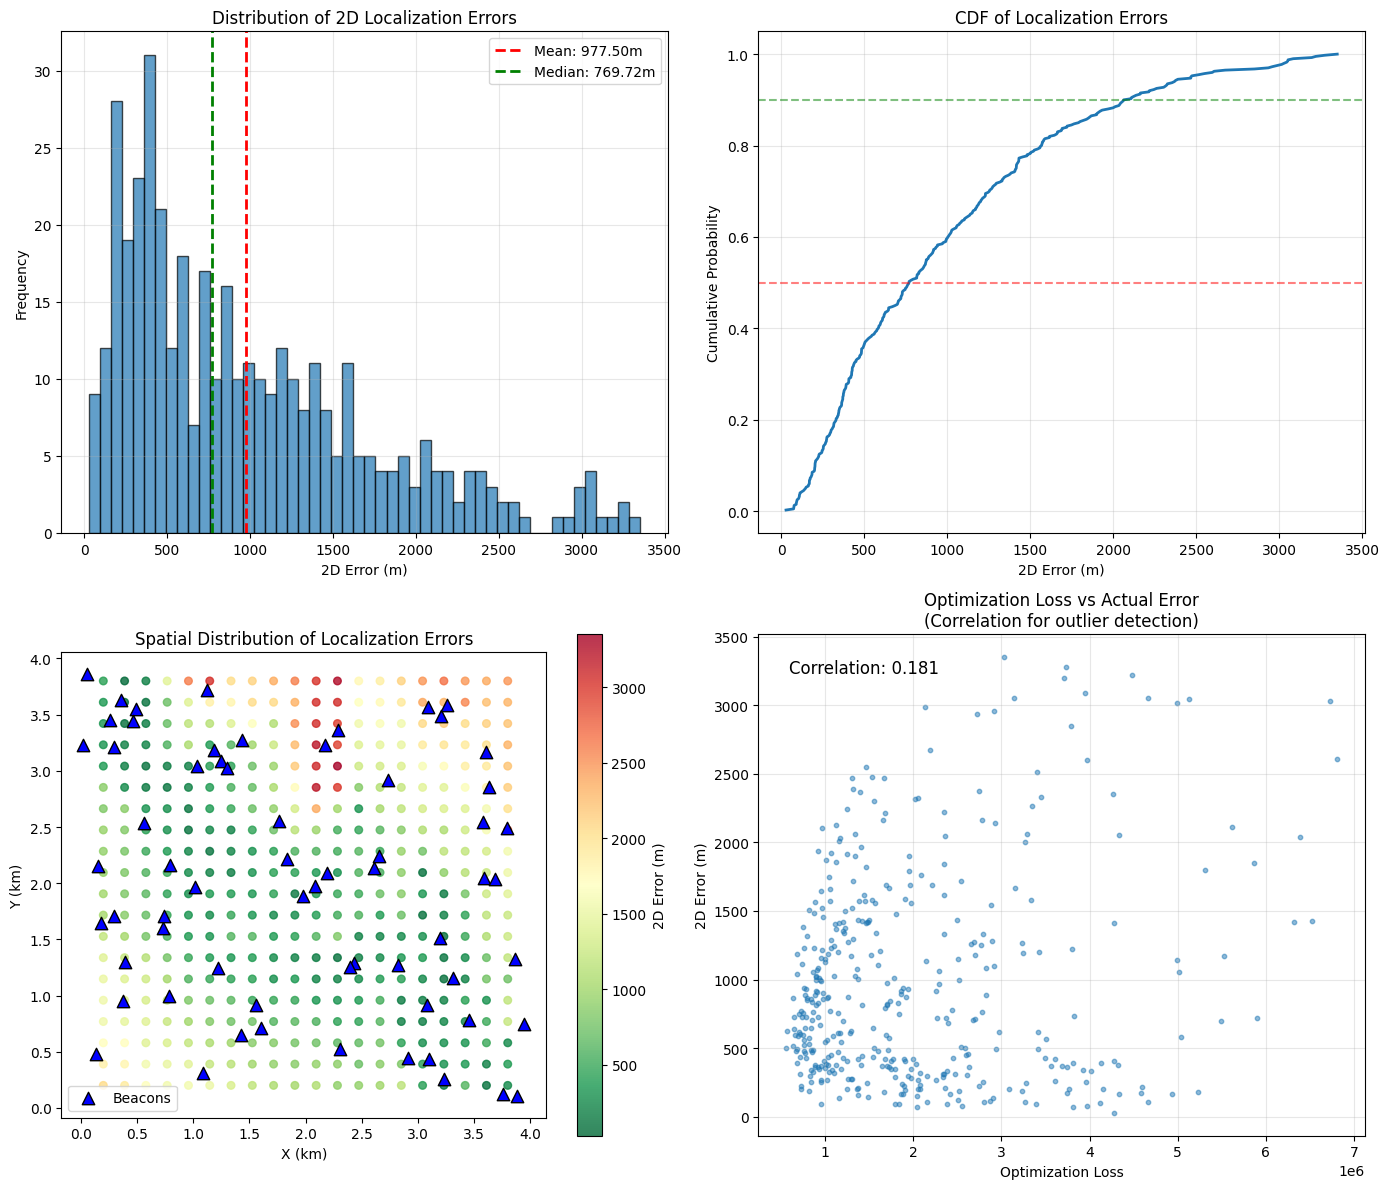

Results saved to localization_results.png


In [58]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Error histogram
ax1 = axes[0, 0]
ax1.hist(errors_2d, bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(errors_2d.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {errors_2d.mean():.2f}m')
ax1.axvline(np.median(errors_2d), color='g', linestyle='--', linewidth=2, label=f'Median: {np.median(errors_2d):.2f}m')
ax1.set_xlabel('2D Error (m)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of 2D Localization Errors')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: CDF
ax2 = axes[0, 1]
sorted_errors = np.sort(errors_2d)
cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
ax2.plot(sorted_errors, cdf, linewidth=2)
ax2.axhline(0.5, color='r', linestyle='--', alpha=0.5)
ax2.axhline(0.9, color='g', linestyle='--', alpha=0.5)
ax2.set_xlabel('2D Error (m)')
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('CDF of Localization Errors')
ax2.grid(True, alpha=0.3)

# Plot 3: Spatial error heatmap
ax3 = axes[1, 0]
scatter = ax3.scatter(drone_x/1000, drone_y/1000, c=errors_2d, cmap='RdYlGn_r', 
                       s=30, alpha=0.8)
ax3.scatter(beacon_x/1000, beacon_y/1000, c='blue', s=80, marker='^', 
            label='Beacons', zorder=5, edgecolors='black')
plt.colorbar(scatter, ax=ax3, label='2D Error (m)')
ax3.set_xlabel('X (km)')
ax3.set_ylabel('Y (km)')
ax3.set_title('Spatial Distribution of Localization Errors')
ax3.legend()
ax3.set_aspect('equal')

# Plot 4: Optimization loss vs error
ax4 = axes[1, 1]
ax4.scatter(optimization_losses, errors_2d, alpha=0.5, s=10)
ax4.set_xlabel('Optimization Loss')
ax4.set_ylabel('2D Error (m)')
ax4.set_title('Optimization Loss vs Actual Error\n(Correlation for outlier detection)')
ax4.grid(True, alpha=0.3)

# Calculate correlation
correlation = np.corrcoef(optimization_losses, errors_2d)[0, 1]
ax4.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax4.transAxes,
         fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.savefig('localization_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("Results saved to localization_results.png")


## 7. Visualize Estimated vs True Positions


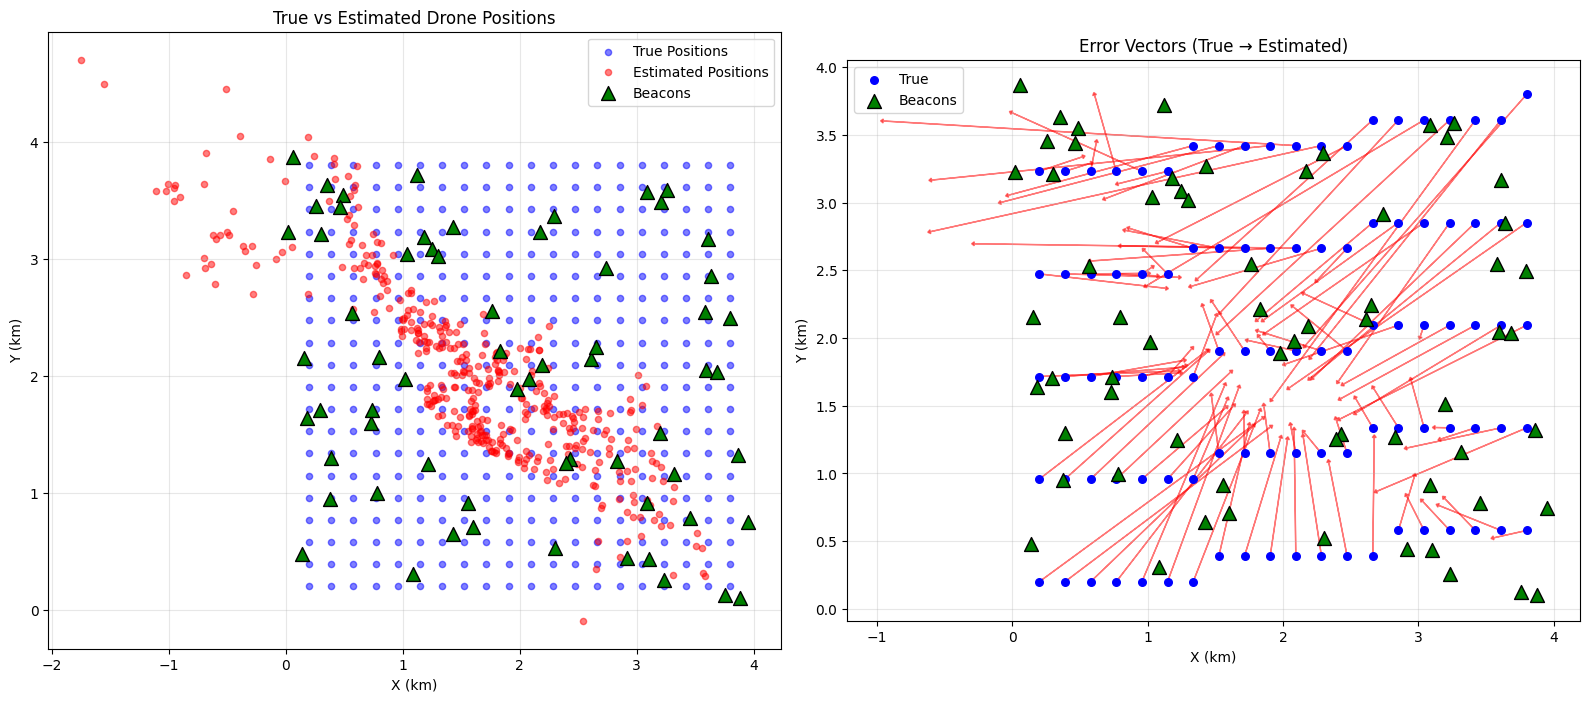

In [59]:
# Convert estimated positions to meters for visualization
estimated_x = np.array([(pos[1] - map_origin_lon) / deg_per_meter_lon for pos in estimated_positions])
estimated_y = np.array([(pos[0] - map_origin_lat) / deg_per_meter_lat for pos in estimated_positions])

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: All positions
ax1 = axes[0]
ax1.scatter(drone_x/1000, drone_y/1000, c='blue', s=20, alpha=0.5, label='True Positions')
ax1.scatter(estimated_x/1000, estimated_y/1000, c='red', s=20, alpha=0.5, label='Estimated Positions')
ax1.scatter(beacon_x/1000, beacon_y/1000, c='green', s=100, marker='^', 
            label='Beacons', zorder=5, edgecolors='black')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.set_title('True vs Estimated Drone Positions')
ax1.legend()
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Plot 2: Error vectors for sample points
ax2 = axes[1]
sample_indices = np.linspace(0, num_drone_positions-1, 100, dtype=int)

for idx in sample_indices:
    ax2.arrow(drone_x[idx]/1000, drone_y[idx]/1000,
              (estimated_x[idx] - drone_x[idx])/1000,
              (estimated_y[idx] - drone_y[idx])/1000,
              head_width=0.03, head_length=0.02, fc='red', ec='red', alpha=0.5)

ax2.scatter(drone_x[sample_indices]/1000, drone_y[sample_indices]/1000, 
            c='blue', s=30, label='True', zorder=3)
ax2.scatter(beacon_x/1000, beacon_y/1000, c='green', s=100, marker='^', 
            label='Beacons', zorder=5, edgecolors='black')
ax2.set_xlabel('X (km)')
ax2.set_ylabel('Y (km)')
ax2.set_title('Error Vectors (True → Estimated)')
ax2.legend()
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('position_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 8. Save Results for Further Analysis (Beacon Location Noise Study)


In [60]:
# Save results to a file for further analysis
results = {
    'true_lat': drone_lat,
    'true_lon': drone_lon,
    'true_x': drone_x,
    'true_y': drone_y,
    'estimated_lat': np.array([pos[0] for pos in estimated_positions]),
    'estimated_lon': np.array([pos[1] for pos in estimated_positions]),
    'estimated_x': estimated_x,
    'estimated_y': estimated_y,
    'errors_2d': errors_2d,
    'errors_3d': errors_3d,
    'optimization_losses': optimization_losses,
    'beacon_lat': beacon_lat,
    'beacon_lon': beacon_lon,
    'beacon_x': beacon_x,
    'beacon_y': beacon_y,
    'model_params': {'A': A_fit, 'n': n_fit},
    'huber_delta': delta,
    'drone_altitude': drone_altitude
}

np.savez('localization_results.npz', **results)
print("Results saved to localization_results.npz")

# Summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Method: Multilateration with Huber Loss + Altitude Constraint")
print(f"Number of beacons: {num_beacons}")
print(f"Number of test positions: {num_drone_positions}")
print(f"Huber delta: {delta}")
print(f"RSSI-to-Distance model: d = 10^(({A_fit:.2f} - RSSI) / (10 * {n_fit:.2f}))")
print(f"\nMean 2D Error: {errors_2d.mean():.2f} m")
print(f"Median 2D Error: {np.median(errors_2d):.2f} m")
print("="*60)


Results saved to localization_results.npz

FINAL SUMMARY
Method: Multilateration with Huber Loss + Altitude Constraint
Number of beacons: 64
Number of test positions: 400
Huber delta: 10.0
RSSI-to-Distance model: d = 10^((23.07 - RSSI) / (10 * 3.58))

Mean 2D Error: 977.50 m
Median 2D Error: 769.72 m


## 9. Study Effect of Beacon Location Noise

This section allows you to add Gaussian noise to beacon positions and see how it affects localization accuracy.


In [61]:
def run_with_beacon_noise(noise_std_meters, num_trials=1):
    """
    Run multilateration with noisy beacon locations.
    
    Parameters:
    -----------
    noise_std_meters : float
        Standard deviation of Gaussian noise added to beacon X/Y positions (in meters)
    num_trials : int
        Number of trials to average over (for stochastic noise)
    
    Returns:
    --------
    dict : Results including mean/median 2D errors
    """
    all_errors_2d = []
    
    for trial in range(num_trials):
        # Add noise to beacon positions
        noisy_beacon_x = beacon_x + np.random.normal(0, noise_std_meters, num_beacons)
        noisy_beacon_y = beacon_y + np.random.normal(0, noise_std_meters, num_beacons)
        
        # Convert noisy positions to lat/lon
        noisy_beacon_lat = map_origin_lat + noisy_beacon_y * deg_per_meter_lat
        noisy_beacon_lon = map_origin_lon + noisy_beacon_x * deg_per_meter_lon
        
        # Create noisy beacon locations
        noisy_beacon_locations = [(noisy_beacon_lat[i], noisy_beacon_lon[i], beacon_height) 
                                   for i in range(num_beacons)]
        
        errors_2d_trial = []
        
        for i in range(num_drone_positions):
            rssi_values = rssi_matrix[i, :]
            estimated_distances = rssi_to_distance(rssi_values, A_fit, n_fit)
            
            estimated_pos, _ = multilaterate(
                noisy_beacon_locations,  # Use noisy beacon locations
                estimated_distances, 
                drone_altitude,
                delta=delta,
                use_altitude_constraint=True
            )
            
            true_pos_2d = to_cartesian_2d(drone_lat[i], drone_lon[i])
            est_pos_2d = to_cartesian_2d(estimated_pos[0], estimated_pos[1])
            errors_2d_trial.append(np.linalg.norm(true_pos_2d - est_pos_2d))
        
        all_errors_2d.append(np.array(errors_2d_trial))
    
    # Average across trials
    avg_errors_2d = np.mean(all_errors_2d, axis=0)
    
    return {
        'noise_std': noise_std_meters,
        'mean_2d': np.mean(avg_errors_2d),
        'median_2d': np.median(avg_errors_2d),
        'std_2d': np.std(avg_errors_2d),
        'errors_2d': avg_errors_2d
    }

print("Beacon noise study function defined.")


Beacon noise study function defined.


Running beacon noise study...


 17%|█▋        | 1/6 [00:02<00:13,  2.76s/it]

  Noise σ =   0 m → Mean 2D Error: 977.50 m, Median: 769.72 m


 33%|███▎      | 2/6 [00:05<00:11,  2.78s/it]

  Noise σ =   5 m → Mean 2D Error: 976.95 m, Median: 771.13 m


 50%|█████     | 3/6 [00:08<00:08,  2.78s/it]

  Noise σ =  10 m → Mean 2D Error: 977.51 m, Median: 776.35 m


 67%|██████▋   | 4/6 [00:11<00:05,  2.82s/it]

  Noise σ =  20 m → Mean 2D Error: 974.08 m, Median: 776.67 m


 83%|████████▎ | 5/6 [00:13<00:02,  2.77s/it]

  Noise σ =  50 m → Mean 2D Error: 975.42 m, Median: 824.16 m


100%|██████████| 6/6 [00:16<00:00,  2.76s/it]

  Noise σ = 100 m → Mean 2D Error: 978.53 m, Median: 789.76 m


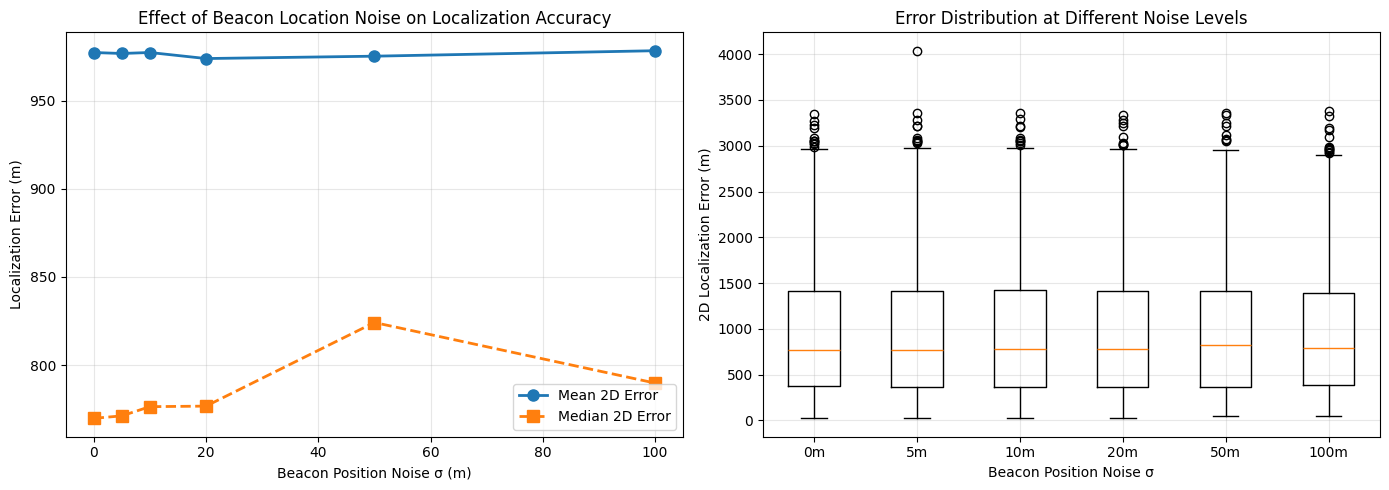


Beacon noise study complete! Results saved to beacon_noise_study.png


In [62]:
# Run beacon noise study with different noise levels
noise_levels = [0, 5, 10, 20, 50, 100]  # meters
noise_results = []

print("Running beacon noise study...")
for noise_std in tqdm(noise_levels):
    result = run_with_beacon_noise(noise_std, num_trials=1)
    noise_results.append(result)
    print(f"  Noise σ = {noise_std:3d} m → Mean 2D Error: {result['mean_2d']:.2f} m, Median: {result['median_2d']:.2f} m")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Error vs Noise Level
ax1 = axes[0]
noise_stds = [r['noise_std'] for r in noise_results]
mean_errors = [r['mean_2d'] for r in noise_results]
median_errors = [r['median_2d'] for r in noise_results]

ax1.plot(noise_stds, mean_errors, 'o-', linewidth=2, markersize=8, label='Mean 2D Error')
ax1.plot(noise_stds, median_errors, 's--', linewidth=2, markersize=8, label='Median 2D Error')
ax1.set_xlabel('Beacon Position Noise σ (m)')
ax1.set_ylabel('Localization Error (m)')
ax1.set_title('Effect of Beacon Location Noise on Localization Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Error distribution for each noise level
ax2 = axes[1]
boxplot_data = [r['errors_2d'] for r in noise_results]
bp = ax2.boxplot(boxplot_data, labels=[f'{n}m' for n in noise_stds])
ax2.set_xlabel('Beacon Position Noise σ')
ax2.set_ylabel('2D Localization Error (m)')
ax2.set_title('Error Distribution at Different Noise Levels')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('beacon_noise_study.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nBeacon noise study complete! Results saved to beacon_noise_study.png")
